In [1]:
# %load_ext autoreload
# %autoreload 2    # tester cette magic function pdt le projet

# %autoreload 0

# Mise en place du notebook

## Import des modules

In [395]:
# pour développement
from pympler import asizeof
import mesfonctions_P7
from importlib import reload
mesfonctions_P7 = reload(mesfonctions_P7)

# from IPython.core.display import HTML
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import Spectral, RdYlGn
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from mesfonctions_P7 import display_scree_plot
from mesfonctions_P7 import display_circles
from mesfonctions_P7 import display_factorial_planes
import pickle
from termcolor import colored, cprint
import re
import imblearn
from collections import Counter
import warnings
from dataprep.eda import create_report
import os
from lightgbm import LGBMClassifier, plot_importance
import pickle
import time
from math import sqrt
import joblib
from pprint import pprint

In [2]:
# Où suis-je ?
dirpath = os.getcwd()
print("Working directory is : " + dirpath)

# List files available
inputpath = dirpath + "/input/"
print("\nFichiers .csv : ", os.listdir(inputpath))

Working directory is : C:\Users\jmjoe\home-credit-default-risk

Fichiers .csv :  ['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


## Gestion des paramètres du Notebook Jupyter

In [3]:
plt.style.use('seaborn')

warnings.simplefilter(category=FutureWarning, action='ignore') 
warnings.simplefilter(category=UserWarning, action='ignore') 

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

## Constantes

## Fonctions courantes

In [414]:
def affichage_scores(grid_search, tri=False) : 
    """Retourne les scores pour les différentes valeurs testées de GridSearch ou GridSearchCV.
    Args :
    - grid_search : instance de  GridSearch après cross-validation.
    - tri : booléen pour effectuer un tri des scores.
    Returns : 
    - print des scores et des paramètres de grid_search correspondant.
    """
    score_name = grid_search.scoring
    cvres = grid_search.cv_results_
    
    # Traitement des résultats
    dummy_list = [x for x in range(len(cvres['mean_test_score']))]    # on est obligés de rajouter cette valeur dummy pour que la méthode sort() ne plante pas car en cas d'égalité de score elle va chercher à comparer des dictionnaires (cvres["params"])
    resultats_zip = zip(cvres['mean_test_score'], dummy_list, cvres['params'], cvres['mean_fit_time'], cvres['mean_train_score'], cvres['std_test_score'])
    resultats_zip = list(resultats_zip)
    if tri:
        resultats_zip.sort(reverse=True)   # tri par score décroissant
        
    # Impression
    df = pd.DataFrame(columns=[score_name, 'params', 'fit_time (s)', 'test/train score', 'std_test_score'])
    for mean_test_score, _, params, fit_time, mean_train_score, std_test_score in resultats_zip:
#         print(score_name, "=", ("%.3f" % mean_test_score).ljust(8, ' '), params, ("%.2f" % fit_time).ljust(8, ' '))
        new_result = pd.DataFrame({score_name : round(mean_test_score, 3), 
                                   'params' : str(params), 
                                   'fit_time (s)' : round(fit_time, 1),
                                   'test/train score' : round(mean_test_score/mean_train_score,3),
                                   'std_test_score' : round(std_test_score, 4)
                                  }, index = [0])
        df=df.append(new_result, ignore_index=True)
#     display(df)
    display(HTML(df.to_html()))
    if not tri:
        print("Best", score_name, "=", ("%.3f" % grid_search.best_score_).ljust(8, ' '), grid_search.best_params_)
    


def EDA(df, samples=10000):
    """Réalise l'analyse exploratoire avec dataprep.
    Args :
    - df : dataframe pandas
    - samples : nb de lignes du df inclues dans l'analyse (si samples=None : on garde le df entier).
    Returns :
    - void (le rapport d'analyse est sauvé dans un fichier pickle et affiché dans une nouvelle fenêtre du web-browser)
    """
    
    def print_var_name(variable):
        """Convertit un nom de variable en string"""
        for name in globals():
            if eval(name) is variable and name not in ['_', '__', '___']:
                return name
    
    # sampling
    samples = samples if len(df) > samples else None
    text_samples = "max" if samples is None else str(samples)
    df_sampled = df.sample(samples, random_state=0)
    
    # un pickle est chargé si le rapport existe déjà sinon un rapport est créé
    nom_rapport = print_var_name(df) + " - EDA pour Projet 7 - " + text_samples + " samples" 
    try:
        rapport = pickle.load(open(nom_rapport + ".pkl", 'rb'))
        print("Chargement du fichier : " + nom_rapport + ".pkl")
    except FileNotFoundError:
        print("Calcul du rapport... ", end='')
        rapport = create_report(df_sampled, title=nom_rapport, config={"insight.skewed.threshold": 0})
        print("Calcul terminé. Sauvegarde sous forme de pickle.")
        pickle.dump(rapport, open(nom_rapport + ".pkl", 'wb'))
    
    # Affichage du rapport dans une nouvelle fenêtre
    print(f"Taille du fichier : {round(os.path.getsize(nom_rapport + '.pkl')/1024/1024)} MB")
    print("Ouverture du rapport dans une nouvelle fenêtre")
    rapport.show_browser()

    
def metriques_classif_binaire(clf, X_validation, y_validation, titre="Courbe ROC du classifieur sur le jeu de validation"):
    """ Affiche la courbe ROC et un histogramme des predict_proba.
    Args : 
    - clf : classifieur sklearn entraîné.
    - X_validation : the input samples.
    - y_validation : the predicted classes.
    - titre : titre de la courbe ROC.
    """
    y_split_valid_pred = clf.predict(X_validation)
    y_split_valid_pred_proba = clf.predict_proba(X_validation)

    # Matrice de confusion
    display(pd.DataFrame(confusion_matrix(y_validation, y_split_valid_pred), columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

    fpr, tpr, thr = roc_curve(y_validation, y_split_valid_pred_proba[:,1])

    # get the best threshold (Youden's J Statistic)
    J = tpr - fpr
    ix = np.argmax(J)
    best_thr = thr[ix]

    # Tracé de la courbe ROC
    plt.figure(edgecolor='black', linewidth=4)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.4f)" % auc(fpr, tpr)
    )
    plt.plot(
        fpr,
        tpr-fpr,
        color="darkgreen",
        lw=2,
        label="Youden J Statistic (best threshold = %0.4f)" % best_thr
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title(titre, fontsize=14)
    plt.legend(loc="upper left", fontsize=12)
    plt.show()
    
    # Tracé de l'histogramme des predict_proba
    bins = 200
    plt.figure(edgecolor='black', linewidth=4)
    plt.hist(y_split_valid_pred_proba[:,1], bins=bins)
    plt.xlim(-0.01, 1.01)
    _, ymax = plt.ylim()
    plt.ylim(-ymax/100, ymax)
    plt.xlabel("predict_proba", size=12)
    plt.ylabel("Count", size=12)
    plt.title(f"Histogramme des predict_proba({bins} bins)", fontsize=14)
    plt.show()

    
def mes_scores():
    """Retourne les scores des précédentes soumissions à Kaggle"""
    !kaggle competitions submissions -c home-credit-default-risk
    
    
def conversion_vers_data_LGBM(df_input, test_size=0.1):
    """Conversion d'un dataframe pandas en dataframe exploitable par LGBM.
    Args :
    - df_input : le dataframe en entrée.
    - test_size : ratio de train_test_split
    Returns :
    - X_train, X_test, y_train, X_split_train, X_split_valid, y_split_train, y_split_valid, list_categorical_features, dict_categorical_features, df_test
    """
    df = df_input.copy()
    print(f"df shape : {df.shape}")
    # Variables catégorielles
    list_categorical_features = []
    dict_categorical_features = {}
    for var in df.columns:
        if df[var].dtype == 'object':
            list_categorical_features.append(var)
    # Remplacement des NaN par 'NAN' dans les variables qualitatives (on peut laisser des NaN dans les variables quantitatives)
    df_enc = df[list_categorical_features].fillna('NAN', inplace=False)
    df[list_categorical_features] = df_enc
    # Encodage des variables catégorielles
    enc = OrdinalEncoder(dtype=int)
    for var in list_categorical_features:
        df[var] = enc.fit_transform(df[[var]])
        dict_categorical_features[var] = list(enc.categories_[0])
    # Préparation de X_train, y_train, X_test
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))     # pour éviter l'erreur : "LightGBMError: Do not support special JSON characters in feature name"
    df_train = df[df['TARGET'].notnull()]
    df_test = df[df['TARGET'].isnull()]
    feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    X_train, y_train = df_train[feats], df_train['TARGET']
    X_test           = df_test[feats]
    print("X_train shape: {}, X_test shape: {}".format(X_train.shape, X_test.shape))    
    # split avec stratification
    df_split_train, df_split_valid = train_test_split(df_train, test_size=test_size, stratify=df_train['TARGET'], random_state=0)
    # séparation entre les variables prédictives (X) et à prédire (y)
    X_split_train, X_split_valid = df_split_train[feats], df_split_valid[feats]
    y_split_train, y_split_valid = df_split_train['TARGET'], df_split_valid['TARGET']
    print("X_split_train shape: {}, X_split_valid shape: {}".format(X_split_train.shape, X_split_valid.shape))
    print("y_split_train shape: {}, y_split_valid shape: {}".format(y_split_train.shape, y_split_valid.shape))
    return X_train, X_test, y_train, X_split_train, X_split_valid, y_split_train, y_split_valid, list_categorical_features, dict_categorical_features, df_test


def conversion_proba_vers_logodd(proba):
    """Convertisseur proba vers log-odd"""
    logit = np.log(proba / (1 - proba))
    return logit


def conversion_logodd_vers_proba(logodd):
    """Convertisseur log-odd vers proba"""
    logistic = 1 / (1 + np.exp(-logodd))
    return logistic


In [415]:
conversion_logodd_vers_proba(0.6)

0.6456563062257954

# Notes

## Liens

Lien vers l'énoncé OC : https://openclassrooms.com/fr/paths/164/projects/632/assignment  
  
Lien vers l'énoncé Kaggle : https://www.kaggle.com/c/home-credit-default-risk/overview  

Lien direct pour télécharger les data : https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip  

Lien vers une prise en main rapide de la data :
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

Mes soumissions à Kaggle : https://www.kaggle.com/c/home-credit-default-risk/submit

## Versionning

Le notebook v26 étant devenu trop gros, je l'ai réorganisé en deux notebooks :  
- notebook v27 : contient les kernels de Koehrsen et d'Aguiar ; suppression des parties postérieures à "Kernel d'Aguiar totalement remis à plat"  
- notebook v30 : suppression des kernels de Koehrsen et d'Aguiar ; contient "Kernel d'Aguiar totalement remis à plat" et parties postérieures.

# Récupération des données et analyse par dataprep

## df_description

In [5]:
df_description = pd.read_csv('input/HomeCredit_columns_description.csv',
                           sep=',',
                           low_memory=False, encoding='ISO-8859-1')

In [6]:
len(df_description)

219

In [7]:
HTML(df_description.to_html())

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


## df_application_train

In [9]:
df_application_train= pd.read_csv('input/application_train.csv',
                           sep=',',
                           low_memory=False)

In [10]:
df_application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [11]:
EDA(df_application_train)

Chargement du fichier : df_application_train - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 124 MB
Ouverture du rapport dans une nouvelle fenêtre


In [12]:
df_application_train[df_application_train['SK_ID_CURR'] == 100002]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## df_application_test

In [517]:
df_application_test = pd.read_csv('input/application_test.csv',
                           sep=',',
                           low_memory=False)

In [518]:
df_application_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Marr

In [519]:
EDA(df_application_test)

Chargement du fichier : df_application_test - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 124 MB
Ouverture du rapport dans une nouvelle fenêtre


## df_bureau

In [16]:
df_bureau = pd.read_csv('input/bureau.csv',
                           sep=',',
                           low_memory=False)

In [17]:
df_bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [18]:
EDA(df_bureau)

Chargement du fichier : df_bureau - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 10 MB
Ouverture du rapport dans une nouvelle fenêtre


In [19]:
df_bureau[df_bureau['SK_ID_CURR'] == 100002]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
675684,100002,6158904,Closed,currency 1,-1125,0,-1038.0,-1038.0,NaN,0,40761.000,NaN,NaN,0.0,Credit card,-1038,0.0
675685,100002,6158905,Closed,currency 1,-476,0,NaN,-48.0,NaN,0,0.000,0.0,NaN,0.0,Credit card,-47,NaN
675686,100002,6158906,Closed,currency 1,-1437,0,-1072.0,-1185.0,0.000,0,135000.000,0.0,0.000,0.0,Consumer credit,-1185,0.0
675687,100002,6158907,Closed,currency 1,-1121,0,-911.0,-911.0,3321.000,0,19071.000,NaN,NaN,0.0,Consumer credit,-906,0.0
675688,100002,6158908,Closed,currency 1,-645,0,85.0,-36.0,5043.645,0,120735.000,0.0,0.000,0.0,Consumer credit,-34,0.0
675689,100002,6158909,Active,currency 1,-103,0,NaN,NaN,40.500,0,31988.565,0.0,31988.565,0.0,Credit card,-24,0.0
1337779,100002,6158903,Active,currency 1,-1042,0,780.0,NaN,NaN,0,450000.000,245781.0,0.000,0.0,Consumer credit,-7,0.0
1486113,100002,6113835,Closed,currency 1,-1043,0,62.0,-967.0,0.000,0,67500.000,NaN,NaN,0.0,Credit card,-758,0.0


## df_bureau_balance

In [20]:
df_bureau_balance = pd.read_csv('input/bureau_balance.csv',
                           sep=',',
                           low_memory=False)

In [21]:
df_bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [22]:
EDA(df_bureau_balance)

Chargement du fichier : df_bureau_balance - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 3 MB
Ouverture du rapport dans une nouvelle fenêtre


In [23]:
df_bureau_balance[df_bureau_balance['SK_ID_BUREAU'] == 6158904]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
13472782,6158904,-15,C
13472783,6158904,-16,C
13472784,6158904,-17,0
13472785,6158904,-18,0
13472786,6158904,-19,0
13472787,6158904,-20,1
13472788,6158904,-21,0
13472789,6158904,-22,0
13472790,6158904,-23,0
13472791,6158904,-24,0


## df_POS_CASH_balance

In [26]:
df_POS_CASH_balance = pd.read_csv('input/POS_CASH_balance.csv',
                           sep=',',
                           low_memory=False)

In [27]:
df_POS_CASH_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [28]:
EDA(df_POS_CASH_balance)

Chargement du fichier : df_POS_CASH_balance - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 4 MB
Ouverture du rapport dans une nouvelle fenêtre


In [29]:
df_POS_CASH_balance[df_POS_CASH_balance['SK_ID_CURR'] == 100002].sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
8473918,1038818,100002,-19,24.0,24.0,Active,0,0
2012884,1038818,100002,-18,24.0,23.0,Active,0,0
5258607,1038818,100002,-17,24.0,22.0,Active,0,0
1216849,1038818,100002,-16,24.0,21.0,Active,0,0
9849444,1038818,100002,-15,24.0,20.0,Active,0,0
7403606,1038818,100002,-14,24.0,19.0,Active,0,0
513222,1038818,100002,-13,24.0,18.0,Active,0,0
9228061,1038818,100002,-12,24.0,17.0,Active,0,0
8701895,1038818,100002,-11,24.0,16.0,Active,0,0
7601963,1038818,100002,-10,24.0,15.0,Active,0,0


## df_credit_card_balance

In [30]:
df_credit_card_balance = pd.read_csv('input/credit_card_balance.csv',
                           sep=',',
                           low_memory=False)

In [31]:
df_credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [32]:
EDA(df_credit_card_balance)

Chargement du fichier : df_credit_card_balance - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 9 MB
Ouverture du rapport dans une nouvelle fenêtre


## df_previous_application

In [33]:
df_previous_application = pd.read_csv('input/previous_application.csv',
                           sep=',',
                           low_memory=False)

In [34]:
df_previous_application

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [35]:
EDA(df_previous_application)

Chargement du fichier : df_previous_application - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 40 MB
Ouverture du rapport dans une nouvelle fenêtre


In [36]:
df_previous_application[df_previous_application['SK_ID_CURR'] == 100002]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
892077,1038818,100002,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,Y,1,0.0,NaN,NaN,XAP,Approved,-606,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0


## df_installments_payments

In [37]:
df_installments_payments = pd.read_csv('input/installments_payments.csv',
                           sep=',',
                           low_memory=False)

In [38]:
df_installments_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [39]:
EDA(df_installments_payments)

Chargement du fichier : df_installments_payments - EDA pour Projet 7 - 10000 samples.pkl
Taille du fichier : 2 MB
Ouverture du rapport dans une nouvelle fenêtre


In [40]:
df_installments_payments[df_installments_payments['SK_ID_CURR'] == 100002].sort_values('NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
2144879,1038818,100002,1.0,1,-565.0,-587.0,9251.775,9251.775
2163032,1038818,100002,1.0,2,-535.0,-562.0,9251.775,9251.775
1675768,1038818,100002,1.0,3,-505.0,-529.0,9251.775,9251.775
3343696,1038818,100002,1.0,4,-475.0,-498.0,9251.775,9251.775
2841063,1038818,100002,1.0,5,-445.0,-468.0,9251.775,9251.775
1807424,1038818,100002,1.0,6,-415.0,-446.0,9251.775,9251.775
3594829,1038818,100002,1.0,7,-385.0,-412.0,9251.775,9251.775
210205,1038818,100002,1.0,8,-355.0,-375.0,9251.775,9251.775
607863,1038818,100002,1.0,9,-325.0,-344.0,9251.775,9251.775
2646927,1038818,100002,1.0,10,-295.0,-312.0,9251.775,9251.775


# Nettoyage

DAYS_EMPLOYED : supprimer les nombreuses lignes à +365K  
OWN_CAR_AGE : mettre age max à 60  
Attention aux triplettes de variables : _AVG _MEDI _MODE.  1) je n'ai pas compris ce que c'est    2) elles sont souvent très corrélées.

# Analyse exploratoire

# Kernels de WILL KOEHRSEN  /  Kernel d' Aguiar

Dispos dans la v26 du notebook, supprimés dans les notebooks >= v30

# Kernel d'Aguiar totalement remis à plat

Les différents tests de imbalanced datasets sont dispo dans la v26 du notebook, et supprimés dans les notebooks >= v30.

## Bloc de calcul qui génère toutes les features

In [5]:
# Mode debug : calculs rapides sur un nb limité de lignes (XXXs pour feature engineering si debug=False)
debug = False
num_rows_debug = 2000
num_rows = num_rows_debug if debug else None

### application_train.csv ###
# Read data and merge
df_all = pd.read_csv('input/application_train.csv', nrows= num_rows)
df_all_app_test = pd.read_csv('input/application_test.csv', nrows= num_rows)
print("Train samples: {}, test samples: {}".format(len(df_all), len(df_all_app_test)))
df_all = df_all.append(df_all_app_test).reset_index()  # les lignes de df_all_app_test sont concaténées après les lignes du dataset train
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df_all['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
# Some simple new features (percentages)
df_all['DAYS_EMPLOYED_PERC'] = df_all['DAYS_EMPLOYED'] / df_all['DAYS_BIRTH']
df_all['INCOME_CREDIT_PERC'] = df_all['AMT_INCOME_TOTAL'] / df_all['AMT_CREDIT']
df_all['INCOME_PER_PERSON'] = df_all['AMT_INCOME_TOTAL'] / df_all['CNT_FAM_MEMBERS']
df_all['ANNUITY_INCOME_PERC'] = df_all['AMT_ANNUITY'] / df_all['AMT_INCOME_TOTAL']
df_all['PAYMENT_RATE'] = df_all['AMT_ANNUITY'] / df_all['AMT_CREDIT']
del df_all_app_test
print(f"Shape after application_train.csv : {df_all.shape}")

### bureau.csv and bureau_balance.csv ###
bureau = pd.read_csv('input/bureau.csv', nrows = num_rows)
bb = pd.read_csv('input/bureau_balance.csv', nrows = num_rows)
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del bb, bb_agg
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE'] == 'Active']
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed']
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
# joining main df_all
df_all = df_all.join(bureau_agg, how='left', on='SK_ID_CURR')
del active, active_agg, closed, closed_agg, bureau, bureau_agg
print(f"Shape after bureau.csv and bureau_balance.csv : {df_all.shape}")

### previous_application.csv ###
prev = pd.read_csv('input/previous_application.csv', nrows = num_rows)
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS'] == 'Approved']
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS'] == 'Refused']
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
df_all = df_all.join(prev_agg, how='left', on='SK_ID_CURR')
del refused, refused_agg, approved, approved_agg, prev, prev_agg
print(f"Shape after previous_application.csv: {df_all.shape}")

### POS_CASH_balance ###
pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
df_all = df_all.join(pos_agg, how='left', on='SK_ID_CURR')
del pos, pos_agg
print(f"Shape after POS_CASH_balance.csv : {df_all.shape}")

### installments_payments ###
ins = pd.read_csv('input/installments_payments.csv', nrows = num_rows)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
df_all = df_all.join(ins_agg, how='left', on='SK_ID_CURR')
del ins, ins_agg
print(f"Shape after installments_payments : {df_all.shape}")

### credit_card_balance ###
cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
# General aggregations
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
df_all = df_all.join(cc_agg, how='left', on='SK_ID_CURR')
del cc, cc_agg
print(f"Shape after credit_card_balance.csv : {df_all.shape}")

Train samples: 307511, test samples: 48744
Shape after application_train.csv : (356255, 128)
Shape after bureau.csv and bureau_balance.csv : (356255, 209)
Shape after previous_application.csv: (356255, 299)
Shape after POS_CASH_balance.csv : (356255, 307)
Shape after installments_payments : (356255, 333)
Shape after credit_card_balance.csv : (356255, 434)


## Préparation des données pour LGBM

In [460]:
X_train, X_test, y_train, X_split_train, X_split_valid, y_split_train, y_split_valid, list_categorical_features, dict_categorical_features, df_test = conversion_vers_data_LGBM(df_all)

df shape : (356255, 434)
X_train shape: (307511, 431), X_test shape: (48744, 431)
X_split_train shape: (276759, 431), X_split_valid shape: (30752, 431)
y_split_train shape: (276759,), y_split_valid shape: (30752,)


In [284]:
joblib.dump(list_categorical_features, './dashboard_streamlit/src/list_categorical_features.joblib') 

['./dashboard_streamlit/src/list_categorical_features.joblib']

In [7]:
list_categorical_features = joblib.load('./dashboard_streamlit/src/list_categorical_features.joblib')
list_categorical_features

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [461]:
pprint(dict_categorical_features)

{'CODE_GENDER': ['F', 'M', 'XNA'],
 'EMERGENCYSTATE_MODE': ['NAN', 'No', 'Yes'],
 'FLAG_OWN_CAR': ['N', 'Y'],
 'FLAG_OWN_REALTY': ['N', 'Y'],
 'FONDKAPREMONT_MODE': ['NAN',
                        'not specified',
                        'org spec account',
                        'reg oper account',
                        'reg oper spec account'],
 'HOUSETYPE_MODE': ['NAN',
                    'block of flats',
                    'specific housing',
                    'terraced house'],
 'NAME_CONTRACT_TYPE': ['Cash loans', 'Revolving loans'],
 'NAME_EDUCATION_TYPE': ['Academic degree',
                         'Higher education',
                         'Incomplete higher',
                         'Lower secondary',
                         'Secondary / secondary special'],
 'NAME_FAMILY_STATUS': ['Civil marriage',
                        'Married',
                        'Separated',
                        'Single / not married',
                        'Unknown',
           

In [463]:
joblib.dump(dict_categorical_features, './dashboard_streamlit/src/dict_categorical_features.joblib') 

['./dashboard_streamlit/src/dict_categorical_features.joblib']

## Classification avec LightGBM

### Entrainement sur X_train, prédiction sur test set et soummission à Kaggle

In [8]:
clf = LGBMClassifier()
clf.fit(X_train, y_train, eval_metric='auc', verbose=-1, categorical_feature=list_categorical_features)

LGBMClassifier()

In [9]:
y_test_pred_proba = clf.predict_proba(X_test)
clf.predict(X_test).sum()

148.0

In [10]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred_proba[:,1]})

In [11]:
submission.to_csv('lgbm_toutes_les_features_v8.csv', index = False)

In [12]:
!kaggle competitions submit -c home-credit-default-risk -f lgbm_toutes_les_features_v8.csv -m "lgbm_toutes_les_features"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.31M [00:00<?, ?B/s]
  1%|          | 8.00k/1.31M [00:00<00:17, 77.4kB/s]
 45%|####5     | 608k/1.31M [00:00<00:00, 3.55MB/s] 
100%|##########| 1.31M/1.31M [00:05<00:00, 251kB/s]


### Entrainement sur X_split_train

In [14]:
clf = LGBMClassifier()
clf.fit(X_split_train, y_split_train, eval_metric= 'auc', verbose=-1, categorical_feature=list_categorical_features)

LGBMClassifier()

In [15]:
clf.predict(X_test).sum()

153.0

###### Courbe ROC du set de validation

,Predicted 0,Predicted 1
Actual 0,28203,66
Actual 1,2397,86


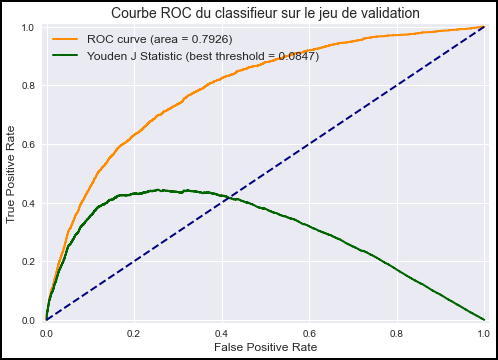

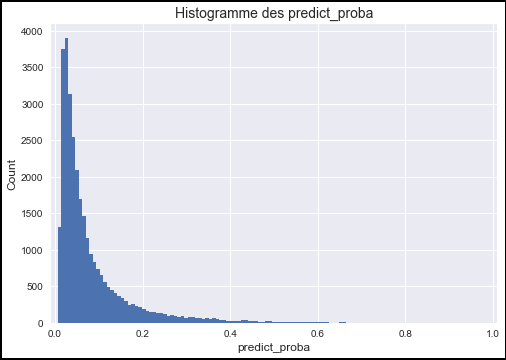

In [16]:
metriques_classif_binaire(clf, X_split_valid, y_split_valid)

# GridSearchCV sur LGBM

## GridSearchCV à 1 dimension pour estimer les ranges des hyperparamètres

In [200]:
X_split_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,...,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_

###### num_leaves

In [85]:
param_grid = [{'num_leaves': [7, 15, 31, 63, 127]}]

clf = LGBMClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True, verbose=10, n_jobs=5)
grid_search.fit(X_split_train, y_split_train, eval_metric= 'auc', verbose=-1, categorical_feature=list_categorical_features)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=5,
             param_grid=[{'num_leaves': [7, 15, 31, 63, 127]}],
             return_train_score=True, scoring='roc_auc', verbose=10)

In [86]:
affichage_scores(grid_search)

,roc_auc,params,fit_time (s),test/train score
0,0.774,{'num_leaves': 7},48.0,0.985
1,0.779,{'num_leaves': 15},56.8,0.965
2,0.780,{'num_leaves': 31},69.2,0.927
3,0.778,{'num_leaves': 63},86.4,0.873
4,0.774,{'num_leaves': 127},121.4,0.814


Best roc_auc = 0.780    {'num_leaves': 31}


###### num_iterations

In [47]:
param_grid = [{'num_iterations': [25, 50, 100, 200, 400]}]

clf = LGBMClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True, verbose=10, n_jobs=5)
grid_search.fit(X_split_train, y_split_train, eval_metric= 'auc', verbose=-1, categorical_feature=list_categorical_features)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=5,
             param_grid=[{'num_iterations': [25, 50, 100, 200, 400]}],
             return_train_score=True, scoring='roc_auc', verbose=10)

In [84]:
affichage_scores(grid_search)

,roc_auc,params,fit_time (s),test/train score
0,0.761,{'num_iterations': 25},36.3,0.973
1,0.773,{'num_iterations': 50},49.7,0.957
2,0.780,{'num_iterations': 100},71.3,0.927
3,0.780,{'num_iterations': 200},108.4,0.882
4,0.778,{'num_iterations': 400},167.6,0.833


Best roc_auc = 0.780    {'num_iterations': 200}


###### min_data_in_leaf 

In [87]:
param_grid = [{'min_data_in_leaf': [5, 10, 20, 40, 80]}]

clf = LGBMClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True, verbose=10, n_jobs=5)
grid_search.fit(X_split_train, y_split_train, eval_metric= 'auc', verbose=-1, categorical_feature=list_categorical_features)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=5,
             param_grid=[{'min_data_in_leaf': [5, 10, 20, 40, 80]}],
             return_train_score=True, scoring='roc_auc', verbose=10)

In [88]:
affichage_scores(grid_search)

,roc_auc,params,fit_time (s),test/train score
0,0.779,{'min_data_in_leaf': 5},70.8,0.922
1,0.779,{'min_data_in_leaf': 10},73.6,0.923
2,0.780,{'min_data_in_leaf': 20},71.0,0.927
3,0.780,{'min_data_in_leaf': 40},72.6,0.930
4,0.780,{'min_data_in_leaf': 80},76.3,0.932


Best roc_auc = 0.780    {'min_data_in_leaf': 80}


###### learning_rate

In [89]:
param_grid = [{'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4]}]

clf = LGBMClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True, verbose=10, n_jobs=5)
grid_search.fit(X_split_train, y_split_train, eval_metric= 'auc', verbose=-1, categorical_feature=list_categorical_features)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=5,
             param_grid=[{'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4]}],
             return_train_score=True, scoring='roc_auc', verbose=10)

In [90]:
affichage_scores(grid_search)

,roc_auc,params,fit_time (s),test/train score
0,0.763,{'learning_rate': 0.025},80.2,0.973
1,0.775,{'learning_rate': 0.05},80.9,0.957
2,0.780,{'learning_rate': 0.1},74.4,0.927
3,0.773,{'learning_rate': 0.2},66.7,0.884
4,0.753,{'learning_rate': 0.4},58.5,0.836


Best roc_auc = 0.780    {'learning_rate': 0.1}


## GridSearchCV multidimensionnel

Si je le refais : ajouter l'hyperparamètre {'is_unbalance': [True, False]}

In [97]:
param_grid = [{'num_leaves': [15, 31, 63], 'num_iterations': [50, 100, 200], 'min_data_in_leaf' : [10, 20, 40], 'learning_rate' : [0.05, 0.1, 0.2]}]

clf = LGBMClassifier()

grid_search_MD = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=5, verbose=10)

grid_search_MD.fit(X_split_train, y_split_train, eval_metric= 'auc', verbose=-1, categorical_feature=list_categorical_features)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=5,
             param_grid=[{'learning_rate': [0.05, 0.1, 0.2],
                          'min_data_in_leaf': [10, 20, 40],
                          'num_iterations': [50, 100, 200],
                          'num_leaves': [15, 31, 63]}],
             return_train_score=True, scoring='roc_auc', verbose=10)

In [121]:
affichage_scores(grid_search_MD, tri=True)

,roc_auc,params,fit_time (s),test/train score,std_test_score
0,0.782,"{'learning_rate': 0.1, 'min_data_in_leaf': 40, 'num_iterations': 200, 'num_leaves': 15}",85.0,0.938,0.0011
1,0.782,"{'learning_rate': 0.05, 'min_data_in_leaf': 40, 'num_iterations': 200, 'num_leaves': 31}",123.8,0.929,0.0013
2,0.781,"{'learning_rate': 0.05, 'min_data_in_leaf': 40, 'num_iterations': 200, 'num_leaves': 63}",160.2,0.876,0.0012
3,0.781,"{'learning_rate': 0.05, 'min_data_in_leaf': 20, 'num_iterations': 200, 'num_leaves': 63}",154.3,0.871,0.0015
4,0.781,"{'learning_rate': 0.05, 'min_data_in_leaf': 20, 'num_iterations': 200, 'num_leaves': 31}",120.8,0.926,0.0012
5,0.781,"{'learning_rate': 0.1, 'min_data_in_leaf': 20, 'num_iterations': 200, 'num_leaves': 15}",84.8,0.934,0.0003
6,0.781,"{'learning_rate': 0.05, 'min_data_in_leaf': 10, 'num_iterations': 200, 'num_leaves': 31}",122.4,0.922,0.0017
7,0.781,"{'learning_rate': 0.05, 'min_data_in_leaf': 10, 'num_iterations': 200, 'num_leaves': 63}",156.4,0.866,0.0016
8,0.781,"{'learning_rate': 0.1, 'min_data_in_leaf': 10, 'num_iterations': 200, 'num_leaves': 15}",83.9,0.932,0.0009
9,0.780,"{'learning_rate': 0.05, 'min_data_in_leaf': 40, 'num_iterations': 200, 'num_leaves': 15}",97.3,0.966,0.0010


In [99]:
pickle.dump(grid_search_MD, open('grid_search_MD.pkl', 'wb'))

In [12]:
grid_search_MD  = pickle.load(open('grid_search_MD.pkl', 'rb'))

In [13]:
best_params = grid_search_MD.best_params_
best_params

{'learning_rate': 0.1,
 'min_data_in_leaf': 40,
 'num_iterations': 200,
 'num_leaves': 15}

### Exploitation de l'optimum du GridSearch

#### Courbe ROC du set de validation

,Predicted 0,Predicted 1
Actual 0,28197,72
Actual 1,2383,100


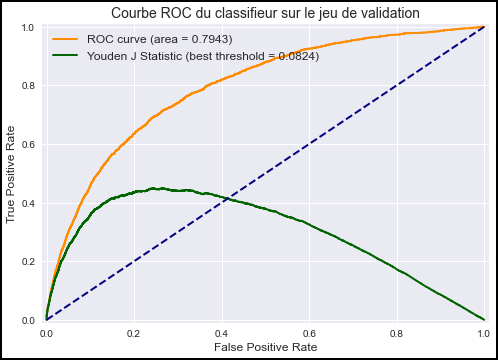

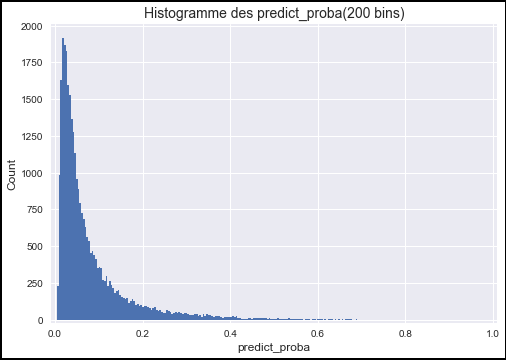

In [12]:
metriques_classif_binaire(grid_search_MD, X_split_valid, y_split_valid)

#### Entrainement sur X_train, prédiction sur test set et soummission à Kaggle

In [146]:
clf_optim = LGBMClassifier(**best_params)
clf_optim.fit(X_train, y_train, eval_metric= 'auc', verbose=-1, categorical_feature=list_categorical_features)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


LGBMClassifier(min_data_in_leaf=40, num_iterations=200, num_leaves=15)

In [148]:
y_test_pred_proba = clf_optim.predict_proba(X_test)
clf_optim.predict(X_test).sum()

170.0

In [149]:
# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': df_test['SK_ID_CURR'], 'TARGET': y_test_pred_proba[:,1]})

In [151]:
submission.to_csv('lgbm_optim_gridsearchcv_v1.csv', index = False)

In [152]:
!kaggle competitions submit -c home-credit-default-risk -f lgbm_optim_gridsearchcv_v1.csv -m "lgbm_optim_gridsearchcv"

Successfully submitted to Home Credit Default Risk



  0%|          | 0.00/1.31M [00:00<?, ?B/s]
  1%|          | 8.00k/1.31M [00:00<00:18, 74.9kB/s]
 31%|###       | 416k/1.31M [00:00<00:00, 2.28MB/s] 
100%|##########| 1.31M/1.31M [00:05<00:00, 268kB/s]


|Objet|Public Score|Private Score|
|-|-|-|
|Toutes les features avec le feature engineering d'Aguiar|0.78696|0.77976|
|Features de "application_train" avec mon feature engineering|0.76129|0.75486|
|Features de "application_train", "bureau", "bureau_balance" avec mon feature engineering|0.76811|0.76355|
|Features de "application_train", "bureau", "bureau_balance", "previous_applications" avec mon feature engineering|0.76836|0.76723|
|Toutes les Features avec mon feature engineering|0.77947|0.77856|
|Toutes les Features avec mon feature engineering + optimisation GridSearchCV|0.78162|0.78028|

# Fonction coût métier

## Fonction utilisée

On va utiliser les hypothèses suivantes pour chaque candidat au crédit :  
- frais généraux pour chaque client : coût = 1.
- gain par client qui rembourse le crédit = 10 (les "True Negative")(octroi de crédit à un client solvable).
- coût par client qui fait défaut = 100 (les "False Negative)(octroi de crédit à un client non-solvable).
- absence de coûts additionnels pour les "True Positive" (refus de crédit à un client non-solvable).
- absence de coûts additionnels pour les "False Positive" (refus de crédit à un client solvable).

Plutôt qu'utiliser une fonction coût, on va préférer une fonction gain construite ainsi :  
$Gain = \frac{10*TN-100*FN-1*(TP+TN+FP+FN)}{TP+TN+FP+FN}$

Cette fonction est borné entre -101 (l'algo ne génère que des FP) et 9 (l'algo est parfait et ne génère que des TN).  

In [11]:
def gain_metier(TP, TN, FP, FN, gain_TN=10, cout_FN=100):
    return (gain_TN*TN-cout_FN*FN-(TP+TN+FP+FN))/(TP+TN+FP+FN)

## Calcul de l'optimum (mauvaise méthode : data leak car optimum trouvé via le jeu de validation)

In [15]:
y_split_valid_pred_proba = grid_search_MD.predict_proba(X_split_valid)

validation_set_pred_proba = pd.DataFrame({'SK_ID_CURR': X_split_valid.index, 'pred_proba': y_split_valid_pred_proba[:,1], 'TARGET_True' : y_split_valid.astype(int)})

In [16]:
def gain_modelise(seuil, verbose=False):
    "Retourne le gain métier en fonction du seuil."
    ser_TARGET_pred = (validation_set_pred_proba['pred_proba'] > seuil).astype(int)
    TP = ((validation_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 1)).sum()
    TN = ((validation_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 0)).sum()
    FP = ((validation_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 1)).sum()
    FN = ((validation_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 0)).sum()
    if verbose:
        return TP, TN, FP, FN, gain_metier(TP, TN, FP, FN)
    else:
        return gain_metier(TP, TN, FP, FN)

gain_modelise(0.5)

0.42007023933402704

In [17]:
seuils = np.linspace(0, 1, 1001)
gains_modelises = [gain_modelise(seuil) for seuil in seuils]

# Quelle est la valeur de seuil qui conduit au max ?
max_value = max(gains_modelises)
max_index = gains_modelises.index(max_value)
max_seuil = seuils[max_index]
print("Seuil qui conduit au maximum de la fonction gain métier :", max_seuil)
print("Valeur maximum de la fonction gain métier :", round(max_value,2))

Seuil qui conduit au maximum de la fonction gain métier : 0.088
Valeur maximum de la fonction gain métier : 3.46


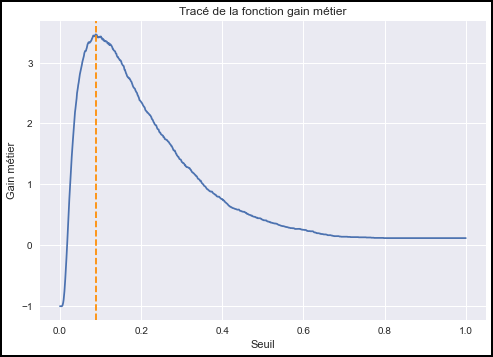

In [18]:
plt.figure(edgecolor='black', linewidth=4)
plt.plot(seuils, gains_modelises)
plt.xlabel('Seuil')
plt.ylabel('Gain métier')
plt.title('Tracé de la fonction gain métier')
plt.axline((max_seuil, 0), (max_seuil, 1), c='darkorange', ls='dashed')
plt.show()

In [19]:
# Quelle est la matrice de confusion à l'optimum ?
TP, TN, FP, FN, _ = gain_modelise(seuil=max_seuil, verbose=True)
display(pd.DataFrame([[TN, FP],[FN, TP]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

,Predicted 0,Predicted 1
Actual 0,21354,6915
Actual 1,763,1720


### Discussion avec Nathalie : fonction de coût/gain du guide mentor vs ma fonction

In [24]:
# fonction guide mentor
def gain_metier(TP, TN, FP, FN):
    return -(10*FN+FP)/(TP+TN+FP+FN)

In [25]:
gains_modelises_fct_guide_mentor = [gain_modelise(seuil) for seuil in seuils]

# Quelle est la valeur de seuil qui conduit au max ?
max_value = max(gains_modelises_fct_guide_mentor)
max_index = gains_modelises_fct_guide_mentor.index(max_value)
max_seuil = seuils[max_index]
print("Seuil qui conduit au maximum de la fonction gain métier :", max_seuil)
print("Valeur maximum de la fonction gain métier :", round(max_value,2))

Seuil qui conduit au maximum de la fonction gain métier : 0.088
Valeur maximum de la fonction gain métier : -0.47


In [26]:
# fonction JMJ
def gain_metier(TP, TN, FP, FN):
    return (1*TN-10*FN-0.1*(TP+TN+FP+FN))/(TP+TN+FP+FN)

In [27]:
gains_modelises_fct_JMJ = [gain_modelise(seuil) for seuil in seuils]

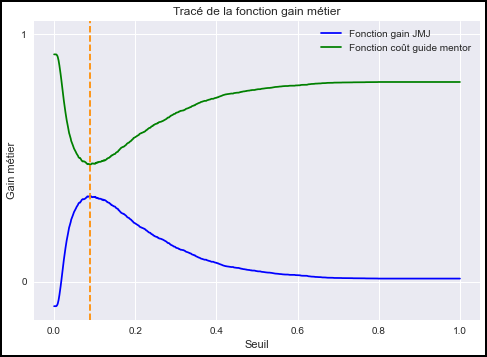

In [39]:
plt.figure(edgecolor='black', linewidth=4)
plt.plot(seuils, gains_modelises_fct_JMJ, c='blue', label = 'Fonction gain JMJ')
plt.plot(seuils, [- gain for gain in gains_modelises_fct_guide_mentor], c='green', label = 'Fonction coût guide mentor')
plt.xlabel('Seuil')
plt.ylabel('Gain métier')
plt.yticks(range(-1,100))
plt.title('Tracé de la fonction gain métier')
plt.axline((max_seuil, 0), (max_seuil, 1), c='darkorange', ls='dashed')
# plt.xlim(0, 0.1)
plt.legend()
plt.show()

Interprétation mathématique : la somme de ces deux fonctions est TN+FP/(TP+TN+FP+FN) , càd les "true 0", ce qui est constant.

## Calcul de l'optimum (bonne méthode : optimum trouvé avec jeu d'entrainement)

### Détermination du seuil pour l'optimum sur le train set

In [40]:
y_split_train_pred_proba = grid_search_MD.predict_proba(X_split_train)

train_set_pred_proba = pd.DataFrame({'SK_ID_CURR': X_split_train.index, 'pred_proba': y_split_train_pred_proba[:,1], 'TARGET_True' : y_split_train.astype(int)})

In [62]:
def gain_modelise(seuil, verbose=False):
    "Retourne le gain métier en fonction du seuil."
    ser_TARGET_pred = (train_set_pred_proba['pred_proba'] > seuil).astype(int)
    TP = ((train_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 1)).sum()
    TN = ((train_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 0)).sum()
    FP = ((train_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 1)).sum()
    FN = ((train_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 0)).sum()
    if verbose:
        return TP, TN, FP, FN, gain_metier(TP, TN, FP, FN)
    else:
        return gain_metier(TP, TN, FP, FN)

In [47]:
seuils = np.linspace(0, 1, 1001)
gains_modelises = [gain_modelise(seuil) for seuil in seuils]

# Quelle est la valeur de seuil qui conduit au max ?
max_value_train = max(gains_modelises)
max_index = gains_modelises.index(max_value_train)
max_seuil = seuils[max_index]
print("Seuil qui conduit au maximum de la fonction gain métier :", max_seuil)
print("Valeur maximum de la fonction gain métier :", round(max_value_train,2))

Seuil qui conduit au maximum de la fonction gain métier : 0.093
Valeur maximum de la fonction gain métier : 3.85


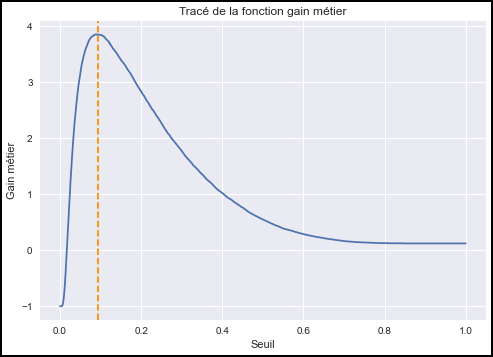

In [43]:
plt.figure(edgecolor='black', linewidth=4)
plt.plot(seuils, gains_modelises)
plt.xlabel('Seuil')
plt.ylabel('Gain métier')
plt.title('Tracé de la fonction gain métier')
plt.axline((max_seuil, 0), (max_seuil, 1), c='darkorange', ls='dashed')
plt.show()

In [44]:
# Quelle est la matrice de confusion à l'optimum ?
TP, TN, FP, FN, _ = gain_modelise(seuil=max_seuil, verbose=True)
display(pd.DataFrame([[TN, FP],[FN, TP]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

,Predicted 0,Predicted 1
Actual 0,197205,57212
Actual 1,6298,16044


###### En aparté : test de sklego pour faire varier le seuil

sklego souffre d'un défaut majeur : il faut refaire un fit du modèle pour chaque valeur de seuil.

### Calcul de l'optimum sur le validation set

In [48]:
y_split_valid_pred_proba = grid_search_MD.predict_proba(X_split_valid)

validation_set_pred_proba = pd.DataFrame({'SK_ID_CURR': X_split_valid.index, 'pred_proba': y_split_valid_pred_proba[:,1], 'TARGET_True' : y_split_valid.astype(int)})

In [63]:
def gain_modelise(seuil, verbose=False):
    "Retourne le gain métier en fonction du seuil."
    ser_TARGET_pred = (validation_set_pred_proba['pred_proba'] > seuil).astype(int)
    TP = ((validation_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 1)).sum()
    TN = ((validation_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 0)).sum()
    FP = ((validation_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 1)).sum()
    FN = ((validation_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 0)).sum()
    if verbose:
        return TP, TN, FP, FN, gain_metier(TP, TN, FP, FN)
    else:
        return gain_metier(TP, TN, FP, FN)

In [56]:
print(f"Pour la valeur de seuil de {max_seuil} (trouvée grace au train set), "
      f"l'optimum de la fonction de coût pour le validation set est de {round(gain_modelise(max_seuil), 2)}.")
print(f"Pour rappel : cet optimum est de {round(max_value_train,2)} sur le train set.")
      
      

Pour la valeur de seuil de 0.093 (trouvée grace au train set), l'optimum de la fonction de coût pour le validation set est de 3.42.
Pour rappel : cet optimum est de 3.85 sur le train set.


La différence d'optimum (3.42 vs 3.85) est significative ! Malgré les tailles du train et du valid set.  
Pour mémoire, avec du dataleak on obtenait un optimum à 3.46.  

In [57]:
# Quelle est la matrice de confusion à l'optimum ?
TP, TN, FP, FN, _ = gain_modelise(seuil=max_seuil, verbose=True)
display(pd.DataFrame([[TN, FP],[FN, TP]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

,Predicted 0,Predicted 1
Actual 0,21848,6421
Actual 1,827,1656


# Optimisation de LGBM avec fonction de perte de l'algo = fonction de coût métier

## Ancien gain métier (valeur de référence, avec fonction de perte = 'logloss')

In [29]:
clf_ref_eval_metric = LGBMClassifier(verbose=100)
clf_ref_eval_metric.fit(X_split_train, y_split_train, eval_metric=None, verbose=100, categorical_feature=list_categorical_features)

[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.803888
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.398379
[LightGBM] [Debug] init for col-wise cost 0.098728 seconds, init for row-wise cost 0.620980 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.756514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81112
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 427
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432506
[LightGBM] [Info] Start training from score -2.432506
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves =

LGBMClassifier(verbose=100)

### Détermination du seuil pour l'optimum sur le train set

In [219]:
y_split_train_pred_proba = clf_ref_eval_metric.predict_proba(X_split_train)

train_set_pred_proba = pd.DataFrame({'SK_ID_CURR': X_split_train.index, 'pred_proba': y_split_train_pred_proba[:,1], 'TARGET_True' : y_split_train.astype(int)})

In [220]:
def gain_modelise(seuil, verbose=False):
    "Retourne le gain métier en fonction du seuil."
    ser_TARGET_pred = (train_set_pred_proba['pred_proba'] > seuil).astype(int)
    TP = ((train_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 1)).sum()
    TN = ((train_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 0)).sum()
    FP = ((train_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 1)).sum()
    FN = ((train_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 0)).sum()
    if verbose:
        return TP, TN, FP, FN, gain_metier(TP, TN, FP, FN)
    else:
        return gain_metier(TP, TN, FP, FN)

In [221]:
seuils = np.linspace(0, 1, 1001)
gains_modelises = [gain_modelise(seuil) for seuil in seuils]

# Quelle est la valeur de seuil qui conduit au max ?
max_value_train = max(gains_modelises)
max_index = gains_modelises.index(max_value_train)
max_seuil = seuils[max_index]
print("Seuil qui conduit au maximum de la fonction gain métier :", max_seuil)
print("Valeur maximum de la fonction gain métier :", round(max_value_train,2))

Seuil qui conduit au maximum de la fonction gain métier : 0.091
Valeur maximum de la fonction gain métier : 3.95


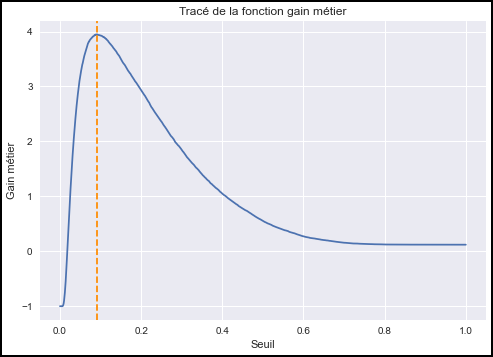

In [222]:
plt.figure(edgecolor='black', linewidth=4)
plt.plot(seuils, gains_modelises)
plt.xlabel('Seuil')
plt.ylabel('Gain métier')
plt.title('Tracé de la fonction gain métier')
plt.axline((max_seuil, 0), (max_seuil, 1), c='darkorange', ls='dashed')
plt.show()

In [223]:
# Quelle est la matrice de confusion à l'optimum ?
TP, TN, FP, FN, _ = gain_modelise(seuil=max_seuil, verbose=True)
display(pd.DataFrame([[TN, FP],[FN, TP]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

,Predicted 0,Predicted 1
Actual 0,196420,57997
Actual 1,5948,16394


### Calcul de l'optimum sur le validation set

In [224]:
y_split_valid_pred_proba = clf_ref_eval_metric.predict_proba(X_split_valid)

validation_set_pred_proba = pd.DataFrame({'SK_ID_CURR': X_split_valid.index, 'pred_proba': y_split_valid_pred_proba[:,1], 'TARGET_True' : y_split_valid.astype(int)})

In [225]:
def gain_modelise(seuil, verbose=False):
    "Retourne le gain métier en fonction du seuil."
    ser_TARGET_pred = (validation_set_pred_proba['pred_proba'] > seuil).astype(int)
    TP = ((validation_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 1)).sum()
    TN = ((validation_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 0)).sum()
    FP = ((validation_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 1)).sum()
    FN = ((validation_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 0)).sum()
    if verbose:
        return TP, TN, FP, FN, gain_metier(TP, TN, FP, FN)
    else:
        return gain_metier(TP, TN, FP, FN)

In [226]:
print(f"Pour la valeur de seuil de {max_seuil} (trouvée grace au train set), "
      f"l'optimum de la fonction de coût pour le validation set est de {round(gain_modelise(max_seuil), 2)}.")
print(f"Pour rappel : cet optimum est de {round(max_value_train,2)} sur le train set.")

Pour la valeur de seuil de 0.091 (trouvée grace au train set), l'optimum de la fonction de coût pour le validation set est de 3.4.
Pour rappel : cet optimum est de 3.95 sur le train set.


La différence d'optimum (3.40 vs 3.95) est significative ! Malgré les tailles du train et du valid set.  

In [227]:
# Quelle est la matrice de confusion à l'optimum ?
TP, TN, FP, FN, _ = gain_modelise(seuil=max_seuil, verbose=True)
display(pd.DataFrame([[TN, FP],[FN, TP]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

,Predicted 0,Predicted 1
Actual 0,21729,6540
Actual 1,820,1663


## Nouveau gain métier (avec fonction de perte customisée)

### Fonction de perte customisée

In [52]:
def gain_metier(TP, TN, FP, FN):
    return (10*TN-100*FN-(TP+TN+FP+FN))/(TP+TN+FP+FN)

In [53]:
my_verbose = True ; cycle = 1 ; seuil_optimum = -999999.9 ; last_y_pred_pd = 0 ; external_gain_metier_max = -999999.9
def my_eval_metric(y_true, y_pred, test_unitaire=False):
    """C'est la fonction de perte de LGBM baséee sur la fonction coût métier.
    Args :
    - y_true : array-like of shape = [n_samples]. The target values.
    - y_pred : array-like of shape = [n_samples] or shape = [n_samples * n_classes] The predicted values. 
            In case of custom objective, predicted values are returned before any transformation, e.g. they are raw margin 
            instead of probability of positive class for binary task in this case.
    Returns : 
    - nom de la métrique (string).
    - loss value (float).
    - is_higher_better (booléen).
    Note : contrairement à ce qui est décrit dans la documentation de LGBM, y_pred est une proba (certe farfelue). 
        C'est le même score que celui retourné par la méthode predict_proba(raw_score=False).
    """
    
    global seuil_optimum, last_y_pred_pd, external_gain_metier_max
    y_pred_pd = pd.Series(y_pred)
    
    # Maximisation du gain_metier : on teste les seuils de proba et on retient celui qui donne le meilleur gain métier.
    gain_metier_max = -999999.9
    seuils = np.linspace(0.070, 0.110, 41) if not test_unitaire else [0]
    for seuil in seuils:
        # Calcul des TP / TN / FP / FN
        y_pred_bool = (y_pred_pd > seuil).astype(int)    # conversion des raw margins en booléen (0 ou 1)
        TP = ((y_true == 1) & (y_pred_bool == 1)).sum()
        TN = ((y_true == 0) & (y_pred_bool == 0)).sum()
        FP = ((y_true == 0) & (y_pred_bool == 1)).sum()
        FN = ((y_true == 1) & (y_pred_bool == 0)).sum()
        # Calcul du gain métier
        gain = gain_metier(TP, TN, FP, FN)
        # copie des valeurs optimales
        if gain > gain_metier_max:
            gain_metier_max = gain
            seuil_optimum = seuil
            TN_optimum = TN
            FP_optimum = FP
            FN_optimum = FN
            TP_optimum = TP
            
    
    # print verbose
    if my_verbose:
        if test_unitaire:
            display(y_pred_pd)
            display(y_pred_bool)
        global cycle
        str_verbose = f"cycle = {cycle}, seuil_optimum = {round(seuil_optimum, 3)}, gain_metier_max = {round(gain_metier_max, 4)}"
        print(str_verbose)
        cycle += 1
        display(y_pred_pd.head(5))
        display(pd.DataFrame([[TN_optimum, FP_optimum],[FN_optimum, TP_optimum]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))
    
    # return
    external_gain_metier_max = gain_metier_max
    loss = -gain_metier_max
    is_higher_better = False
    
    return "ma_fonction_coût", loss, is_higher_better


###### Tests unitaires (test_unitaire = True)

In [145]:
# Test unitaire 1 : la fonction de coût classe tous les candidats en classe 1
my_verbose = True ; cycle = 1 ; string_verbose = ""
y_true = np.array([0, 1, 1, 0, 1])
y_pred = np.array([4, 2, 3, 2, 1.5])
my_eval_metric(y_true, y_pred, test_unitaire=True)

0    4.0
1    2.0
2    3.0
3    2.0
4    1.5
dtype: float64

0    1
1    1
2    1
3    1
4    1
dtype: int32

cycle = 1, seuil_optimum = 0, gain_metier_max = -1.0


0    4.0
1    2.0
2    3.0
3    2.0
4    1.5
dtype: float64

,Predicted 0,Predicted 1
Actual 0,0,2
Actual 1,0,3


('ma_fonction_coût', 1.0, False)

In [146]:
# Test unitaire 2 : la fonction de coût classe tous les candidats solvables en classe 0
my_verbose = True ; cycle = 1 ; string_verbose = ""
y_true = np.array([0, 1, 1, 0, 1])
y_pred = np.array([-4, -2, -3, -2, -1.5])
my_eval_metric(y_true, y_pred, test_unitaire=True)

0   -4.0
1   -2.0
2   -3.0
3   -2.0
4   -1.5
dtype: float64

0    0
1    0
2    0
3    0
4    0
dtype: int32

cycle = 1, seuil_optimum = 0, gain_metier_max = -57.0


0   -4.0
1   -2.0
2   -3.0
3   -2.0
4   -1.5
dtype: float64

,Predicted 0,Predicted 1
Actual 0,2,0
Actual 1,3,0


('ma_fonction_coût', 57.0, False)

### Fit du classifieur LGBM

In [193]:
# fit d'un classifieur avec les paramètres par défaut de LGBM et la fonction de coût my_eval_metric
my_verbose = True ; cycle = 1
clf_my_eval_metric = LGBMClassifier(verbose=100, n_estimators=100)

# attention : j'ai dû mettre un eval_set pour que eval_metric soit pris en compte (c'est aberrant, mais ça évite un bug) - à surveiller de près lors de la cross-validation
clf_my_eval_metric.fit(X_split_train, y_split_train, eval_metric=my_eval_metric, verbose=100, categorical_feature=list_categorical_features, eval_set=[(X_split_train, y_split_train)])


[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.803888
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.398379
[LightGBM] [Debug] init for col-wise cost 0.104166 seconds, init for row-wise cost 0.633478 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.743635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 81112
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 427
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432506
[LightGBM] [Info] Start training from score -2.432506
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 1, seuil_optimum = 0.081, gain_metier_max = 2.3325


0    0.082404
1    0.075975
2    0.082738
3    0.077274
4    0.077274
dtype: float64

,Predicted 0,Predicted 1
Actual 0,177899,76518
Actual 1,8567,13775


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 2, seuil_optimum = 0.083, gain_metier_max = 2.4395


0    0.091033
1    0.073669
2    0.083327
3    0.074891
4    0.085416
dtype: float64

,Predicted 0,Predicted 1
Actual 0,180421,73996
Actual 1,8523,13819


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 3, seuil_optimum = 0.085, gain_metier_max = 2.523


0    0.090169
1    0.071045
2    0.083807
3    0.074250
4    0.084693
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196751,57666
Actual 1,9925,12417


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 4, seuil_optimum = 0.085, gain_metier_max = 2.6036


0    0.088518
1    0.067113
2    0.081526
3    0.071744
4    0.083133
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189013,65404
Actual 1,8928,13414


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 5, seuil_optimum = 0.087, gain_metier_max = 2.6576


0    0.088048
1    0.064956
2    0.080776
3    0.067771
4    0.081039
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191988,62429
Actual 1,9076,13266


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 6, seuil_optimum = 0.089, gain_metier_max = 2.6759


0    0.089143
1    0.061549
2    0.080524
3    0.064938
4    0.078501
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193733,60684
Actual 1,9200,13142


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 7, seuil_optimum = 0.088, gain_metier_max = 2.7102


0    0.091521
1    0.061774
2    0.080812
3    0.061117
4    0.080621
dtype: float64

,Predicted 0,Predicted 1
Actual 0,190894,63523
Actual 1,8821,13521


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 8, seuil_optimum = 0.092, gain_metier_max = 2.7596


0    0.092849
1    0.060006
2    0.077874
3    0.063034
4    0.078695
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197061,57356
Actual 1,9301,13041


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 9, seuil_optimum = 0.089, gain_metier_max = 2.7834


0    0.091872
1    0.058450
2    0.077903
3    0.060033
4    0.076516
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191059,63358
Actual 1,8635,13707


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 10, seuil_optimum = 0.089, gain_metier_max = 2.8211


0    0.090024
1    0.058293
2    0.077699
3    0.057137
4    0.074106
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189933,64484
Actual 1,8418,13924


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 11, seuil_optimum = 0.091, gain_metier_max = 2.8575


0    0.087990
1    0.056658
2    0.075543
3    0.059896
4    0.072004
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192669,61748
Actual 1,8591,13751


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 12, seuil_optimum = 0.089, gain_metier_max = 2.8786


0    0.090993
1    0.055449
2    0.076662
3    0.058623
4    0.070230
dtype: float64

,Predicted 0,Predicted 1
Actual 0,188924,65493
Actual 1,8158,14184


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 13, seuil_optimum = 0.093, gain_metier_max = 2.9064


0    0.091942
1    0.054053
2    0.079731
3    0.057257
4    0.070979
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194364,60053
Actual 1,8625,13717


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 14, seuil_optimum = 0.093, gain_metier_max = 2.939


0    0.093502
1    0.053787
2    0.079350
3    0.057743
4    0.069858
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194304,60113
Actual 1,8529,13813


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 15, seuil_optimum = 0.092, gain_metier_max = 2.968


0    0.091013
1    0.053352
2    0.078725
3    0.054821
4    0.067951
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192637,61780
Actual 1,8282,14060


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 16, seuil_optimum = 0.089, gain_metier_max = 2.9954


0    0.091938
1    0.051985
2    0.077681
3    0.055400
4    0.069568
dtype: float64

,Predicted 0,Predicted 1
Actual 0,188476,65941
Actual 1,7790,14552


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 17, seuil_optimum = 0.093, gain_metier_max = 3.016


0    0.097673
1    0.052217
2    0.081801
3    0.055713
4    0.074022
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193586,60831
Actual 1,8244,14098


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 18, seuil_optimum = 0.089, gain_metier_max = 3.0569


0    0.096385
1    0.050773
2    0.084055
3    0.058906
4    0.072309
dtype: float64

,Predicted 0,Predicted 1
Actual 0,188698,65719
Actual 1,7642,14700


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 19, seuil_optimum = 0.087, gain_metier_max = 3.0794


0    0.097229
1    0.050984
2    0.084392
3    0.058055
4    0.072959
dtype: float64

,Predicted 0,Predicted 1
Actual 0,186131,68286
Actual 1,7323,15019


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 20, seuil_optimum = 0.091, gain_metier_max = 3.102


0    0.097650
1    0.052149
2    0.084331
3    0.056883
4    0.071218
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191427,62990
Actual 1,7790,14552


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 21, seuil_optimum = 0.091, gain_metier_max = 3.1232


0    0.096131
1    0.052220
2    0.082999
3    0.054727
4    0.070078
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191434,62983
Actual 1,7732,14610


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 22, seuil_optimum = 0.093, gain_metier_max = 3.1454


0    0.095503
1    0.050663
2    0.080603
3    0.055763
4    0.068027
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193669,60748
Actual 1,7894,14448


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 23, seuil_optimum = 0.091, gain_metier_max = 3.1664


0    0.095241
1    0.052401
2    0.089326
3    0.053580
4    0.067299
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191308,63109
Actual 1,7600,14742


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 24, seuil_optimum = 0.091, gain_metier_max = 3.1877


0    0.092730
1    0.050575
2    0.088890
3    0.055903
4    0.065471
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191338,63079
Actual 1,7544,14798


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 25, seuil_optimum = 0.093, gain_metier_max = 3.1999


0    0.092750
1    0.051846
2    0.090905
3    0.057529
4    0.065486
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193767,60650
Actual 1,7753,14589


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 26, seuil_optimum = 0.093, gain_metier_max = 3.2214


0    0.090609
1    0.051246
2    0.090504
3    0.060658
4    0.063930
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193961,60456
Actual 1,7713,14629


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 27, seuil_optimum = 0.092, gain_metier_max = 3.239


0    0.089886
1    0.050819
2    0.088875
3    0.059185
4    0.062746
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192937,61480
Actual 1,7562,14780


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 28, seuil_optimum = 0.095, gain_metier_max = 3.2511


0    0.089918
1    0.052598
2    0.088907
3    0.057554
4    0.061024
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196284,58133
Actual 1,7863,14479


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 29, seuil_optimum = 0.09, gain_metier_max = 3.2715


0    0.094691
1    0.051782
2    0.087580
3    0.056604
4    0.060086
dtype: float64

,Predicted 0,Predicted 1
Actual 0,190917,63500
Actual 1,7270,15072


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 30, seuil_optimum = 0.09, gain_metier_max = 3.2873


0    0.094072
1    0.053756
2    0.085051
3    0.055550
4    0.060484
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191115,63302
Actual 1,7246,15096


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 31, seuil_optimum = 0.09, gain_metier_max = 3.2982


0    0.094491
1    0.052736
2    0.085433
3    0.058388
4    0.062267
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191277,63140
Actual 1,7232,15110


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 32, seuil_optimum = 0.09, gain_metier_max = 3.3115


0    0.094344
1    0.052651
2    0.088446
3    0.057023
4    0.062316
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191346,63071
Actual 1,7202,15140


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 33, seuil_optimum = 0.089, gain_metier_max = 3.3222


0    0.093358
1    0.054616
2    0.087515
3    0.055150
4    0.061642
dtype: float64

,Predicted 0,Predicted 1
Actual 0,190321,64096
Actual 1,7070,15272


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
cycle = 34, seuil_optimum = 0.088, gain_metier_max = 3.3368


0    0.093019
1    0.054310
2    0.087196
3    0.057326
4    0.061411
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189424,64993
Actual 1,6940,15402


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 35, seuil_optimum = 0.093, gain_metier_max = 3.3508


0    0.093234
1    0.056103
2    0.087399
3    0.055434
4    0.060898
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194772,59645
Actual 1,7436,14906


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 36, seuil_optimum = 0.088, gain_metier_max = 3.3641


0    0.096472
1    0.056011
2    0.086629
3    0.057231
4    0.060346
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189730,64687
Actual 1,6895,15447


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 37, seuil_optimum = 0.09, gain_metier_max = 3.3767


0    0.096826
1    0.054975
2    0.088788
3    0.057450
4    0.060576
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191970,62447
Actual 1,7084,15258


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 38, seuil_optimum = 0.089, gain_metier_max = 3.3872


0    0.094551
1    0.055404
2    0.086684
3    0.055888
4    0.059097
dtype: float64

,Predicted 0,Predicted 1
Actual 0,190899,63518
Actual 1,6948,15394


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 39, seuil_optimum = 0.09, gain_metier_max = 3.3986


0    0.095127
1    0.055760
2    0.085658
3    0.054513
4    0.057911
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192044,62373
Actual 1,7031,15311


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
cycle = 40, seuil_optimum = 0.091, gain_metier_max = 3.4149


0    0.094134
1    0.055152
2    0.087462
3    0.056513
4    0.058258
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193187,61230
Actual 1,7100,15242


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 41, seuil_optimum = 0.09, gain_metier_max = 3.4253


0    0.094161
1    0.053341
2    0.085065
3    0.056530
4    0.057631
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192333,62084
Actual 1,6986,15356


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 42, seuil_optimum = 0.093, gain_metier_max = 3.438


0    0.096033
1    0.051380
2    0.084025
3    0.056814
4    0.059251
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195275,59142
Actual 1,7245,15097


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 43, seuil_optimum = 0.089, gain_metier_max = 3.4473


0    0.094496
1    0.052541
2    0.082663
3    0.055653
4    0.059075
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191532,62885
Actual 1,6845,15497


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 44, seuil_optimum = 0.087, gain_metier_max = 3.4579


0    0.094624
1    0.054261
2    0.082723
3    0.057415
4    0.058027
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189627,64790
Actual 1,6625,15717


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 45, seuil_optimum = 0.089, gain_metier_max = 3.4675


0    0.094597
1    0.054082
2    0.081990
3    0.057227
4    0.056652
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191741,62676
Actual 1,6810,15532


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 46, seuil_optimum = 0.094, gain_metier_max = 3.4817


0    0.096335
1    0.054112
2    0.081308
3    0.057258
4    0.057285
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196606,57811
Actual 1,7257,15085


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 47, seuil_optimum = 0.092, gain_metier_max = 3.4861


0    0.095531
1    0.054138
2    0.083085
3    0.056710
4    0.055681
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194837,59580
Actual 1,7068,15274


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 48, seuil_optimum = 0.094, gain_metier_max = 3.4972


0    0.097222
1    0.054092
2    0.085106
3    0.058130
4    0.054938
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196705,57712
Actual 1,7224,15118


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 49, seuil_optimum = 0.094, gain_metier_max = 3.5081


0    0.098424
1    0.054453
2    0.087142
3    0.057395
4    0.055649
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196737,57680
Actual 1,7197,15145


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 50, seuil_optimum = 0.089, gain_metier_max = 3.5199


0    0.096136
1    0.056937
2    0.085464
3    0.057855
4    0.056096
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192183,62234
Actual 1,6709,15633


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 51, seuil_optimum = 0.092, gain_metier_max = 3.5311


0    0.094911
1    0.058105
2    0.084990
3    0.057548
4    0.055350
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195052,59365
Actual 1,6965,15377


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 52, seuil_optimum = 0.092, gain_metier_max = 3.5453


0    0.094448
1    0.058299
2    0.085887
3    0.057256
4    0.055068
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195144,59273
Actual 1,6935,15407


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 53, seuil_optimum = 0.091, gain_metier_max = 3.5541


0    0.094678
1    0.057781
2    0.085272
3    0.056746
4    0.054172
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194240,60177
Actual 1,6820,15522


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 54, seuil_optimum = 0.092, gain_metier_max = 3.557


0    0.093357
1    0.056779
2    0.085721
3    0.058415
4    0.054728
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195229,59188
Actual 1,6911,15431


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 55, seuil_optimum = 0.09, gain_metier_max = 3.5622


0    0.092660
1    0.056919
2    0.087100
3    0.058559
4    0.053233
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193512,60905
Actual 1,6725,15617


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
cycle = 56, seuil_optimum = 0.091, gain_metier_max = 3.5763


0    0.092095
1    0.056558
2    0.087694
3    0.058970
4    0.052894
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194484,59933
Actual 1,6783,15559


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 57, seuil_optimum = 0.092, gain_metier_max = 3.5801


0    0.091965
1    0.056473
2    0.086257
3    0.058882
4    0.054270
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195439,58978
Actual 1,6868,15474


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 58, seuil_optimum = 0.096, gain_metier_max = 3.5918


0    0.091741
1    0.056160
2    0.085795
3    0.057841
4    0.053969
dtype: float64

,Predicted 0,Predicted 1
Actual 0,199022,55395
Actual 1,7194,15148


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 59, seuil_optimum = 0.088, gain_metier_max = 3.6055


0    0.089996
1    0.056611
2    0.085909
3    0.056413
4    0.054360
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191881,62536
Actual 1,6442,15900


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 60, seuil_optimum = 0.093, gain_metier_max = 3.614


0    0.089777
1    0.056469
2    0.085699
3    0.057063
4    0.054987
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196476,57941
Actual 1,6878,15464


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 61, seuil_optimum = 0.092, gain_metier_max = 3.628


0    0.089402
1    0.055123
2    0.084204
3    0.056815
4    0.055521
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195685,58732
Actual 1,6760,15582


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 62, seuil_optimum = 0.094, gain_metier_max = 3.6394


0    0.089733
1    0.055335
2    0.083357
3    0.055810
4    0.055734
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197479,56938
Actual 1,6908,15434


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 63, seuil_optimum = 0.095, gain_metier_max = 3.6495


0    0.087239
1    0.054633
2    0.082069
3    0.055859
4    0.054848
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198340,56077
Actual 1,6966,15376


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 64, seuil_optimum = 0.094, gain_metier_max = 3.6595


0    0.088325
1    0.053743
2    0.081067
3    0.057525
4    0.056647
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197547,56870
Actual 1,6859,15483


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
cycle = 65, seuil_optimum = 0.094, gain_metier_max = 3.6666


0    0.087967
1    0.053516
2    0.080735
3    0.057551
4    0.057681
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197612,56805
Actual 1,6846,15496


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 66, seuil_optimum = 0.094, gain_metier_max = 3.6738


0    0.087839
1    0.052866
2    0.081897
3    0.057465
4    0.060386
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197711,56706
Actual 1,6836,15506


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 67, seuil_optimum = 0.093, gain_metier_max = 3.684


0    0.086502
1    0.053153
2    0.082767
3    0.057774
4    0.062738
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196834,57583
Actual 1,6720,15622


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
cycle = 68, seuil_optimum = 0.093, gain_metier_max = 3.693


0    0.085125
1    0.052861
2    0.082915
3    0.056826
4    0.062397
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196904,57513
Actual 1,6702,15640


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
cycle = 69, seuil_optimum = 0.094, gain_metier_max = 3.7046


0    0.084999
1    0.052395
2    0.082208
3    0.056973
4    0.062558
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197873,56544
Actual 1,6767,15575


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 70, seuil_optimum = 0.09, gain_metier_max = 3.7084


0    0.083656
1    0.052119
2    0.080905
3    0.055882
4    0.061546
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194330,60087
Actual 1,6402,15940


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 71, seuil_optimum = 0.089, gain_metier_max = 3.7158


0    0.083434
1    0.052465
2    0.079702
3    0.056251
4    0.058708
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193505,60912
Actual 1,6299,16043


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
cycle = 72, seuil_optimum = 0.089, gain_metier_max = 3.7234


0    0.083025
1    0.053079
2    0.079151
3    0.056572
4    0.057617
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193604,60813
Actual 1,6288,16054


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
cycle = 73, seuil_optimum = 0.089, gain_metier_max = 3.7346


0    0.084201
1    0.053186
2    0.080272
3    0.056434
4    0.057477
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193654,60763
Actual 1,6262,16080


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
cycle = 74, seuil_optimum = 0.09, gain_metier_max = 3.7415


0    0.083835
1    0.053110
2    0.079151
3    0.055181
4    0.055433
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194544,59873
Actual 1,6332,16010


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 75, seuil_optimum = 0.09, gain_metier_max = 3.7545


0    0.084979
1    0.053218
2    0.079308
3    0.055270
4    0.055546
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194595,59822
Actual 1,6301,16041


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
cycle = 76, seuil_optimum = 0.096, gain_metier_max = 3.7597


0    0.083430
1    0.053591
2    0.077942
3    0.055499
4    0.054565
dtype: float64

,Predicted 0,Predicted 1
Actual 0,199738,54679
Actual 1,6801,15541


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 77, seuil_optimum = 0.096, gain_metier_max = 3.7717


0    0.083906
1    0.053907
2    0.077736
3    0.055825
4    0.054417
dtype: float64

,Predicted 0,Predicted 1
Actual 0,199791,54626
Actual 1,6773,15569


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 78, seuil_optimum = 0.095, gain_metier_max = 3.7788


0    0.083823
1    0.054646
2    0.079201
3    0.054638
4    0.054164
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198968,55449
Actual 1,6671,15671


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 79, seuil_optimum = 0.092, gain_metier_max = 3.7895


0    0.083636
1    0.052234
2    0.079025
3    0.053593
4    0.054843
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196544,57873
Actual 1,6399,15943


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 80, seuil_optimum = 0.095, gain_metier_max = 3.7981


0    0.085451
1    0.052101
2    0.079623
3    0.053263
4    0.053993
dtype: float64

,Predicted 0,Predicted 1
Actual 0,199052,55365
Actual 1,6626,15716


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 81, seuil_optimum = 0.096, gain_metier_max = 3.8045


0    0.084938
1    0.052351
2    0.079857
3    0.053518
4    0.053657
dtype: float64

,Predicted 0,Predicted 1
Actual 0,199928,54489
Actual 1,6696,15646


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 82, seuil_optimum = 0.094, gain_metier_max = 3.8126


0    0.084518
1    0.052083
2    0.080664
3    0.052849
4    0.053383
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198332,56085
Actual 1,6514,15828


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 83, seuil_optimum = 0.092, gain_metier_max = 3.8256


0    0.084612
1    0.052142
2    0.080754
3    0.052756
4    0.053444
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196693,57724
Actual 1,6314,16028


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
cycle = 84, seuil_optimum = 0.094, gain_metier_max = 3.8317


0    0.084317
1    0.052463
2    0.081236
3    0.053170
4    0.053251
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198352,56065
Actual 1,6463,15879


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
cycle = 85, seuil_optimum = 0.094, gain_metier_max = 3.8359


0    0.084073
1    0.052487
2    0.081145
3    0.054394
4    0.052762
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198417,56000
Actual 1,6458,15884


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 86, seuil_optimum = 0.094, gain_metier_max = 3.8471


0    0.085883
1    0.052469
2    0.080754
3    0.054374
4    0.053074
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198478,55939
Actual 1,6433,15909


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
cycle = 87, seuil_optimum = 0.094, gain_metier_max = 3.852


0    0.088095
1    0.052999
2    0.078460
3    0.054144
4    0.053610
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198514,55903
Actual 1,6423,15919


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
cycle = 88, seuil_optimum = 0.093, gain_metier_max = 3.8641


0    0.087867
1    0.053044
2    0.078255
3    0.053966
4    0.053466
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197729,56688
Actual 1,6311,16031


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 89, seuil_optimum = 0.093, gain_metier_max = 3.8693


0    0.089124
1    0.053036
2    0.078244
3    0.053958
4    0.053420
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197761,56656
Actual 1,6300,16042


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
cycle = 90, seuil_optimum = 0.093, gain_metier_max = 3.8738


0    0.088858
1    0.053642
2    0.078008
3    0.055018
4    0.051151
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197766,56651
Actual 1,6288,16054


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
cycle = 91, seuil_optimum = 0.092, gain_metier_max = 3.8829


0    0.087515
1    0.054206
2    0.077809
3    0.055595
4    0.050347
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196978,57439
Actual 1,6184,16158


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 92, seuil_optimum = 0.091, gain_metier_max = 3.8922


0    0.086265
1    0.054549
2    0.076686
3    0.055358
4    0.049599
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196175,58242
Actual 1,6078,16264


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 93, seuil_optimum = 0.091, gain_metier_max = 3.9016


0    0.086122
1    0.054456
2    0.077865
3    0.055263
4    0.049513
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196165,58252
Actual 1,6051,16291


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 94, seuil_optimum = 0.092, gain_metier_max = 3.9115


0    0.085126
1    0.052039
2    0.076957
3    0.054327
4    0.049841
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197070,57347
Actual 1,6114,16228


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
cycle = 95, seuil_optimum = 0.092, gain_metier_max = 3.9135


0    0.083746
1    0.053037
2    0.075825
3    0.053417
4    0.049783
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197136,57281
Actual 1,6115,16227


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
cycle = 96, seuil_optimum = 0.092, gain_metier_max = 3.9216


0    0.083863
1    0.053113
2    0.075932
3    0.053142
4    0.049855
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197141,57276
Actual 1,6093,16249


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 97, seuil_optimum = 0.091, gain_metier_max = 3.9309


0    0.081517
1    0.053271
2    0.076152
3    0.053299
4    0.049657
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196347,58070
Actual 1,5988,16354


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
cycle = 98, seuil_optimum = 0.09, gain_metier_max = 3.9349


0    0.081075
1    0.053398
2    0.075737
3    0.051752
4    0.049378
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195488,58929
Actual 1,5891,16451


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
cycle = 99, seuil_optimum = 0.09, gain_metier_max = 3.9391


0    0.080732
1    0.053009
2    0.076948
3    0.051903
4    0.049162
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195493,58924
Actual 1,5880,16462


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
cycle = 100, seuil_optimum = 0.091, gain_metier_max = 3.948


0    0.080937
1    0.052971
2    0.075799
3    0.052008
4    0.049291
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196420,57997
Actual 1,5948,16394


[100]	training's binary_logloss: 0.221692	training's ma_fonction_coût: -3.94799


LGBMClassifier(verbose=100)

###### Analyse du classifieur (les y_pred sont des "probas")

In [200]:
print("seuil_optimum (proba) :", round(seuil_optimum,3))

seuil_optimum (proba) : 0.091


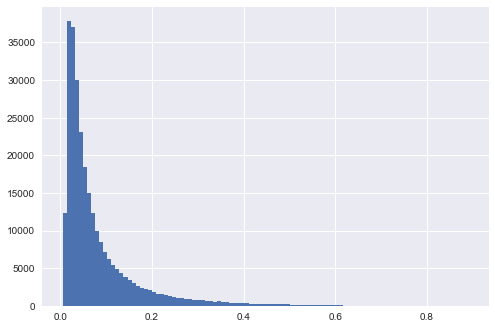

In [199]:
last_y_pred_pd.hist(bins=100);

In [175]:
last_y_pred_pd.nunique()

14644

### Nouveau gain métier

#### Vérification sur X_split_train

##### raw_score=True (mauvais paramètre)

In [204]:
y_split_train_pred_proba_raw = clf_my_eval_metric.predict_proba(X_split_train, raw_score=True)
y_split_train_pred_proba_raw

array([-2.42968694, -2.88358837, -2.50083999, ..., -4.3908885 , -2.62812514, -3.35170615])

In [205]:
y_split_train_pred_proba_raw = clf_my_eval_metric.predict_proba(X_split_train, raw_score=True)

train_set_pred_proba_raw = pd.DataFrame({'SK_ID_CURR': X_split_train.index, 'pred_proba_raw': y_split_train_pred_proba_raw, 'TARGET_True' : y_split_train.astype(int)})

print("Les 20 scores les plus élevés :")
display(train_set_pred_proba_raw.sort_values(by='pred_proba_raw').tail(20))

Les 20 scores les plus élevés :


,SK_ID_CURR,pred_proba_raw,TARGET_True
49450,49450,1.302634,1
119803,119803,1.307751,1
282070,282070,1.321049,1
218872,218872,1.333873,1
47289,47289,1.337998,1
182030,182030,1.343798,1
12448,12448,1.361427,1
164985,164985,1.365750,1
114562,114562,1.366336,1
88652,88652,1.374041,1


##### raw_score=False (bon paramètre : on travaille sur des "probas")

In [206]:
y_split_train_pred_proba = clf_my_eval_metric.predict_proba(X_split_train)
y_split_train_pred_proba

array([[0.91906325, 0.08093675],
       [0.94702916, 0.05297084],
       [0.92420069, 0.07579931],
       ...,
       [0.98776191, 0.01223809],
       [0.93264988, 0.06735012],
       [0.96616066, 0.03383934]])

In [207]:
y_split_train_pred_proba = clf_my_eval_metric.predict_proba(X_split_train)

train_set_pred_proba = pd.DataFrame({'SK_ID_CURR': X_split_train.index, 'pred_proba': y_split_train_pred_proba[:,1], 'TARGET_True' : y_split_train.astype(int)})

print("Les 20 scores les plus élevés :")
display(train_set_pred_proba.sort_values(by='pred_proba').tail(20))

Les 20 scores les plus élevés :


,SK_ID_CURR,pred_proba,TARGET_True
49450,49450,0.786278,1
119803,119803,0.787137,1
282070,282070,0.789356,1
218872,218872,0.791481,1
47289,47289,0.792161,1
182030,182030,0.793114,1
12448,12448,0.795992,1
164985,164985,0.796693,1
114562,114562,0.796788,1
88652,88652,0.798032,1


In [208]:
def gain_modelise(seuil, verbose=False):
    "Retourne le gain métier en fonction du seuil."
    ser_TARGET_pred = (train_set_pred_proba['pred_proba'] > seuil).astype(int)
    TP = ((train_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 1)).sum()
    TN = ((train_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 0)).sum()
    FP = ((train_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 1)).sum()
    FN = ((train_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 0)).sum()
    if verbose:
        return TP, TN, FP, FN, gain_metier(TP, TN, FP, FN)
    else:
        return gain_metier(TP, TN, FP, FN)

In [209]:
print("seuil_optimum : ", round(seuil_optimum, 3))

TP, TN, FP, FN, gain = gain_modelise(seuil_optimum, verbose=True)

print("Gain métier :", round(gain,3))

display(pd.DataFrame([[TN, FP],[FN, TP]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

seuil_optimum :  0.091
Gain métier : 3.948


,Predicted 0,Predicted 1
Actual 0,196420,57997
Actual 1,5948,16394


Parfait. Le résultat est raccord avec les résultats obtenus après le 100è cycle/boost/arbre du fit.  
Note : c'est le même résultat que pour l'ancien gain métier.

#### Calcul sur X_split_valid

In [211]:
y_split_valid_pred_proba = clf_my_eval_metric.predict_proba(X_split_valid)

validation_set_pred_proba = pd.DataFrame({'SK_ID_CURR': X_split_valid.index, 'pred_proba': y_split_valid_pred_proba[:,1], 'TARGET_True' : y_split_valid.astype(int)})

display(validation_set_pred_proba)

,SK_ID_CURR,pred_proba,TARGET_True
81523,81523,0.391317,0
182241,182241,0.064259,0
31786,31786,0.057791,1
120690,120690,0.025997,0
208959,208959,0.077611,0
...,...,...,...
255034,255034,0.027366,0
42871,42871,0.021381,0
215908,215908,0.054002,0
157590,157590,0.085289,0


In [213]:
def gain_modelise(seuil, verbose=False):
    "Retourne le gain métier en fonction du seuil."
    ser_TARGET_pred = (validation_set_pred_proba['pred_proba'] > seuil).astype(int)
    TP = ((validation_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 1)).sum()
    TN = ((validation_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 0)).sum()
    FP = ((validation_set_pred_proba['TARGET_True'] == 0) & (ser_TARGET_pred == 1)).sum()
    FN = ((validation_set_pred_proba['TARGET_True'] == 1) & (ser_TARGET_pred == 0)).sum()
    if verbose:
        return TP, TN, FP, FN, gain_metier(TP, TN, FP, FN)
    else:
        return gain_metier(TP, TN, FP, FN)

In [216]:
print("seuil_optimum (proba) : ", round(seuil_optimum, 3))

TP, TN, FP, FN, gain = gain_modelise(seuil_optimum, verbose=True)

print("Gain métier :", round(gain,3))

display(pd.DataFrame([[TN, FP],[FN, TP]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))

seuil_optimum (proba) :  0.091
Gain métier : 3.399


,Predicted 0,Predicted 1
Actual 0,21729,6540
Actual 1,820,1663


On retrouve les mêmes valeurs que pour l' "ancien gain métier" qui était calculé avec une fonction de perte logloss.

## GridSearchCV sur LGBM en tenant compte de la fonction de coût métier

### Avec GridSearchCV de sklearn

In [13]:
def my_eval_metric_bis(y_true, y_pred):
    """C'est la fonction de perte, basée sur la fonction coût métier, ADAPTEE POUR GRIDSEARCHCV.
    Args :
    y_true : array-like of shape = [n_samples]. The target values.
    y_pred : array-like of shape = [n_samples] or shape = [n_samples * n_classes] The predicted values (probabilités calculées par LGBM)
    Returns : float. Loss value.
    """
    
    y_pred_pd = pd.Series(y_pred)
    
    # Maximisation du gain_metier : on teste les seuils de proba et on retient celui qui donne le meilleur gain métier.
    gain_metier_max = -999999.9
    seuils = np.linspace(0.070, 0.110, 41)
    for seuil in seuils:
        # Calcul des TP / TN / FP / FN
        y_pred_bool = (y_pred_pd > seuil).astype(int)    # conversion des raw margins en booléen (0 ou 1)
        TP = ((y_true == 1) & (y_pred_bool == 1)).sum()
        TN = ((y_true == 0) & (y_pred_bool == 0)).sum()
        FP = ((y_true == 0) & (y_pred_bool == 1)).sum()
        FN = ((y_true == 1) & (y_pred_bool == 0)).sum()
        # Calcul du gain métier
        gain = gain_metier(TP, TN, FP, FN)
        # copie des valeurs optimales
        if gain > gain_metier_max:
            gain_metier_max = gain
            seuil_optimum = seuil
            TN_optimum = TN
            FP_optimum = FP
            FN_optimum = FN
            TP_optimum = TP
            
    
    # print verbose
    if my_verbose:
        str_verbose = f"seuil_optimum = {round(seuil_optimum, 3)}, gain_metier_max = {round(gain_metier_max, 4)}"
        print(str_verbose)
        display(y_pred_pd.head(5))
        display(pd.DataFrame([[TN_optimum, FP_optimum],[FN_optimum, TP_optimum]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))
    
    # return
    loss = -gain_metier_max

    return loss


from sklearn.metrics import make_scorer

scorer_my_eval_metric_bis = make_scorer(score_func=my_eval_metric_bis, greater_is_better=False, needs_proba=True)

In [27]:
# param_grid = [{'num_leaves': [15, 31, 63], 'num_iterations': [50, 100, 200], 'min_data_in_leaf' : [10, 20, 40], 'learning_rate' : [0.05, 0.1, 0.2]}]
param_grid = [{'num_iterations': [5], 'min_data_in_leaf' : [20, 40]}]

clf = LGBMClassifier()

my_verbose = True ; cycle = 1

# grid_search_MD_avec_fonction_cout = GridSearchCV(clf, param_grid, cv=5, scoring=scorer_my_eval_metric_bis, return_train_score=True, n_jobs=1, verbose=10)
grid_search_MD_avec_fonction_cout = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=1, verbose=10)

grid_search_MD_avec_fonction_cout.fit(X_split_train, y_split_train, verbose=10, eval_metric=my_eval_metric, 
                   categorical_feature=list_categorical_features, eval_set=[(X_split_train, y_split_train)])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START min_data_in_leaf=20, num_iterations=5.......................
cycle = 1, seuil_optimum = 0.082, gain_metier_max = 2.353


0    0.079843
1    0.075589
2    0.077575
3    0.077425
4    0.077425
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191386,63031
Actual 1,9859,12483


cycle = 2, seuil_optimum = 0.085, gain_metier_max = 2.4888


0    0.078497
1    0.071259
2    0.079860
3    0.079719
4    0.075200
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198735,55682
Actual 1,10218,12124


cycle = 3, seuil_optimum = 0.086, gain_metier_max = 2.5714


0    0.084630
1    0.068297
2    0.080392
3    0.078993
4    0.074512
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195183,59234
Actual 1,9634,12708


cycle = 4, seuil_optimum = 0.084, gain_metier_max = 2.6329


0    0.087026
1    0.065028
2    0.082209
3    0.075969
4    0.073135
dtype: float64

,Predicted 0,Predicted 1
Actual 0,185825,68592
Actual 1,8528,13814


cycle = 5, seuil_optimum = 0.085, gain_metier_max = 2.6512


0    0.085450
1    0.062355
2    0.082338
3    0.078505
4    0.071791
dtype: float64

,Predicted 0,Predicted 1
Actual 0,186760,67657
Actual 1,8571,13771


[CV 1/5; 1/2] END min_data_in_leaf=20, num_iterations=5;, score=(train=0.736, test=0.729) total time=  11.4s
[CV 2/5; 1/2] START min_data_in_leaf=20, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
cycle = 6, seuil_optimum = 0.082, gain_metier_max = 2.3794


0    0.084140
1    0.077439
2    0.081658
3    0.077379
4    0.077379
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191998,62419
Actual 1,9847,12495


cycle = 7, seuil_optimum = 0.083, gain_metier_max = 2.4907


0    0.083592
1    0.073930
2    0.082598
3    0.076871
4    0.074093
dtype: float64

,Predicted 0,Predicted 1
Actual 0,185637,68780
Actual 1,8903,13439


cycle = 8, seuil_optimum = 0.086, gain_metier_max = 2.5559


0    0.084949
1    0.069616
2    0.083997
3    0.073805
4    0.075308
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198153,56264
Actual 1,9974,12368


cycle = 9, seuil_optimum = 0.085, gain_metier_max = 2.6113


0    0.084531
1    0.066490
2    0.086917
3    0.076251
4    0.074039
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189245,65172
Actual 1,8930,13412


cycle = 10, seuil_optimum = 0.087, gain_metier_max = 2.6534


0    0.085846
1    0.062828
2    0.087750
3    0.072672
4    0.072022
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194251,60166
Actual 1,9314,13028


[CV 2/5; 1/2] END min_data_in_leaf=20, num_iterations=5;, score=(train=0.738, test=0.722) total time=  11.2s
[CV 3/5; 1/2] START min_data_in_leaf=20, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
cycle = 11, seuil_optimum = 0.082, gain_metier_max = 2.329


0    0.083038
1    0.075985
2    0.081863
3    0.077538
4    0.077538
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191494,62923
Actual 1,9936,12406


cycle = 12, seuil_optimum = 0.084, gain_metier_max = 2.4725


0    0.084366
1    0.071663
2    0.083340
3    0.074219
4    0.074219
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192744,61673
Actual 1,9664,12678


cycle = 13, seuil_optimum = 0.085, gain_metier_max = 2.5726


0    0.085566
1    0.067625
2    0.084366
3    0.073608
4    0.071836
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192785,61632
Actual 1,9391,12951


cycle = 14, seuil_optimum = 0.086, gain_metier_max = 2.6168


0    0.086836
1    0.063364
2    0.086536
3    0.074728
4    0.069286
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192977,61440
Actual 1,9288,13054


cycle = 15, seuil_optimum = 0.083, gain_metier_max = 2.6527


0    0.088432
1    0.059875
2    0.085579
3    0.071329
4    0.068032
dtype: float64

,Predicted 0,Predicted 1
Actual 0,180641,73776
Actual 1,7955,14387


[CV 3/5; 1/2] END min_data_in_leaf=20, num_iterations=5;, score=(train=0.738, test=0.725) total time=  11.4s
[CV 4/5; 1/2] START min_data_in_leaf=20, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
cycle = 16, seuil_optimum = 0.082, gain_metier_max = 2.3485


0    0.085423
1    0.076893
2    0.081204
3    0.077517
4    0.077517
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189473,64944
Actual 1,9680,12662


cycle = 17, seuil_optimum = 0.082, gain_metier_max = 2.4335


0    0.088568
1    0.073682
2    0.082536
3    0.074374
4    0.074374
dtype: float64

,Predicted 0,Predicted 1
Actual 0,173604,80813
Actual 1,7858,14484


cycle = 18, seuil_optimum = 0.086, gain_metier_max = 2.5213


0    0.089134
1    0.071104
2    0.084078
3    0.074857
4    0.074857
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197285,57132
Actual 1,9983,12359


cycle = 19, seuil_optimum = 0.086, gain_metier_max = 2.5912


0    0.087792
1    0.067258
2    0.084609
3    0.072299
4    0.073713
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195131,59286
Actual 1,9574,12768


cycle = 20, seuil_optimum = 0.086, gain_metier_max = 2.6377


0    0.088928
1    0.064726
2    0.088408
3    0.070324
4    0.071622
dtype: float64

,Predicted 0,Predicted 1
Actual 0,190656,63761
Actual 1,8998,13344


[CV 4/5; 1/2] END min_data_in_leaf=20, num_iterations=5;, score=(train=0.735, test=0.730) total time=  11.2s
[CV 5/5; 1/2] START min_data_in_leaf=20, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
cycle = 21, seuil_optimum = 0.081, gain_metier_max = 2.3233


0    0.083125
1    0.078450
2    0.079566
3    0.077506
4    0.077506
dtype: float64

,Predicted 0,Predicted 1
Actual 0,185344,69073
Actual 1,9337,13005


cycle = 22, seuil_optimum = 0.084, gain_metier_max = 2.4212


0    0.084993
1    0.074793
2    0.080366
3    0.074110
4    0.074110
dtype: float64

,Predicted 0,Predicted 1
Actual 0,188454,65963
Actual 1,9377,12965


cycle = 23, seuil_optimum = 0.085, gain_metier_max = 2.5106


0    0.083628
1    0.072053
2    0.081162
3    0.070708
4    0.070708
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195809,58608
Actual 1,9865,12477


cycle = 24, seuil_optimum = 0.085, gain_metier_max = 2.612


0    0.085822
1    0.067856
2    0.083242
3    0.067502
4    0.073934
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189646,64771
Actual 1,8968,13374


cycle = 25, seuil_optimum = 0.087, gain_metier_max = 2.6557


0    0.086347
1    0.064832
2    0.084145
3    0.063727
4    0.072044
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193396,61021
Actual 1,9222,13120


[CV 5/5; 1/2] END min_data_in_leaf=20, num_iterations=5;, score=(train=0.738, test=0.724) total time=  11.1s
[CV 1/5; 2/2] START min_data_in_leaf=40, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
cycle = 26, seuil_optimum = 0.082, gain_metier_max = 2.353


0    0.079843
1    0.075589
2    0.077575
3    0.077425
4    0.077425
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191386,63031
Actual 1,9859,12483


cycle = 27, seuil_optimum = 0.084, gain_metier_max = 2.5007


0    0.078497
1    0.071259
2    0.079860
3    0.081563
4    0.075200
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196134,58283
Actual 1,9925,12417


cycle = 28, seuil_optimum = 0.085, gain_metier_max = 2.5742


0    0.084626
1    0.068297
2    0.080391
3    0.080817
4    0.074508
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192419,61998
Actual 1,9350,12992


cycle = 29, seuil_optimum = 0.084, gain_metier_max = 2.6481


0    0.086643
1    0.065028
2    0.082208
3    0.077676
4    0.072806
dtype: float64

,Predicted 0,Predicted 1
Actual 0,185425,68992
Actual 1,8446,13896


cycle = 30, seuil_optimum = 0.086, gain_metier_max = 2.6704


0    0.086305
1    0.063243
2    0.082336
3    0.075447
4    0.070706
dtype: float64

,Predicted 0,Predicted 1
Actual 0,190412,64005
Actual 1,8883,13459


[CV 1/5; 2/2] END min_data_in_leaf=40, num_iterations=5;, score=(train=0.737, test=0.730) total time=  11.1s
[CV 2/5; 2/2] START min_data_in_leaf=40, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
cycle = 31, seuil_optimum = 0.082, gain_metier_max = 2.3794


0    0.084140
1    0.077439
2    0.081658
3    0.077379
4    0.077379
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191998,62419
Actual 1,9847,12495


cycle = 32, seuil_optimum = 0.083, gain_metier_max = 2.4907


0    0.083592
1    0.073930
2    0.082598
3    0.076871
4    0.074093
dtype: float64

,Predicted 0,Predicted 1
Actual 0,185637,68780
Actual 1,8903,13439


cycle = 33, seuil_optimum = 0.086, gain_metier_max = 2.5559


0    0.084949
1    0.069616
2    0.083997
3    0.073805
4    0.075308
dtype: float64

,Predicted 0,Predicted 1
Actual 0,198153,56264
Actual 1,9974,12368


cycle = 34, seuil_optimum = 0.085, gain_metier_max = 2.6126


0    0.084531
1    0.066490
2    0.086917
3    0.076251
4    0.074039
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189121,65296
Actual 1,8914,13428


cycle = 35, seuil_optimum = 0.085, gain_metier_max = 2.6553


0    0.083281
1    0.062828
2    0.087750
3    0.072672
4    0.072931
dtype: float64

,Predicted 0,Predicted 1
Actual 0,187555,66862
Actual 1,8639,13703


[CV 2/5; 2/2] END min_data_in_leaf=40, num_iterations=5;, score=(train=0.738, test=0.722) total time=  11.2s
[CV 3/5; 2/2] START min_data_in_leaf=40, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
cycle = 36, seuil_optimum = 0.082, gain_metier_max = 2.329


0    0.083038
1    0.075985
2    0.081863
3    0.077538
4    0.077538
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191494,62923
Actual 1,9936,12406


cycle = 37, seuil_optimum = 0.084, gain_metier_max = 2.4725


0    0.084366
1    0.071663
2    0.083340
3    0.074219
4    0.074219
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192744,61673
Actual 1,9664,12678


cycle = 38, seuil_optimum = 0.085, gain_metier_max = 2.5726


0    0.085566
1    0.067625
2    0.084366
3    0.073608
4    0.071836
dtype: float64

,Predicted 0,Predicted 1
Actual 0,192785,61632
Actual 1,9391,12951


cycle = 39, seuil_optimum = 0.086, gain_metier_max = 2.6215


0    0.086835
1    0.063364
2    0.086536
3    0.074728
4    0.069286
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191929,62488
Actual 1,9170,13172


cycle = 40, seuil_optimum = 0.088, gain_metier_max = 2.6585


0    0.088432
1    0.059875
2    0.085580
3    0.071328
4    0.068032
dtype: float64

,Predicted 0,Predicted 1
Actual 0,194093,60324
Actual 1,9284,13058


[CV 3/5; 2/2] END min_data_in_leaf=40, num_iterations=5;, score=(train=0.738, test=0.725) total time=  11.2s
[CV 4/5; 2/2] START min_data_in_leaf=40, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
cycle = 41, seuil_optimum = 0.082, gain_metier_max = 2.3485


0    0.085423
1    0.076893
2    0.081204
3    0.077517
4    0.077517
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189473,64944
Actual 1,9680,12662


cycle = 42, seuil_optimum = 0.082, gain_metier_max = 2.4335


0    0.088568
1    0.073682
2    0.082536
3    0.074374
4    0.074374
dtype: float64

,Predicted 0,Predicted 1
Actual 0,173604,80813
Actual 1,7858,14484


cycle = 43, seuil_optimum = 0.086, gain_metier_max = 2.5213


0    0.089134
1    0.071104
2    0.084078
3    0.074857
4    0.074857
dtype: float64

,Predicted 0,Predicted 1
Actual 0,197285,57132
Actual 1,9983,12359


cycle = 44, seuil_optimum = 0.086, gain_metier_max = 2.5912


0    0.087792
1    0.067258
2    0.084609
3    0.072299
4    0.073713
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195131,59286
Actual 1,9574,12768


cycle = 45, seuil_optimum = 0.086, gain_metier_max = 2.6377


0    0.088928
1    0.064726
2    0.088408
3    0.070324
4    0.071622
dtype: float64

,Predicted 0,Predicted 1
Actual 0,190656,63761
Actual 1,8998,13344


[CV 4/5; 2/2] END min_data_in_leaf=40, num_iterations=5;, score=(train=0.735, test=0.730) total time=  11.6s
[CV 5/5; 2/2] START min_data_in_leaf=40, num_iterations=5.......................
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
cycle = 46, seuil_optimum = 0.081, gain_metier_max = 2.3233


0    0.083125
1    0.078450
2    0.079566
3    0.077506
4    0.077506
dtype: float64

,Predicted 0,Predicted 1
Actual 0,185344,69073
Actual 1,9337,13005


cycle = 47, seuil_optimum = 0.084, gain_metier_max = 2.4212


0    0.084993
1    0.074793
2    0.080366
3    0.074110
4    0.074110
dtype: float64

,Predicted 0,Predicted 1
Actual 0,188454,65963
Actual 1,9377,12965


cycle = 48, seuil_optimum = 0.085, gain_metier_max = 2.5106


0    0.083628
1    0.072053
2    0.081162
3    0.070708
4    0.070708
dtype: float64

,Predicted 0,Predicted 1
Actual 0,195809,58608
Actual 1,9865,12477


cycle = 49, seuil_optimum = 0.085, gain_metier_max = 2.612


0    0.085822
1    0.067856
2    0.083242
3    0.067502
4    0.073934
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189646,64771
Actual 1,8968,13374


cycle = 50, seuil_optimum = 0.087, gain_metier_max = 2.6557


0    0.086347
1    0.064832
2    0.084145
3    0.063727
4    0.072044
dtype: float64

,Predicted 0,Predicted 1
Actual 0,193396,61021
Actual 1,9222,13120


[CV 5/5; 2/2] END min_data_in_leaf=40, num_iterations=5;, score=(train=0.738, test=0.724) total time=  11.1s
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
cycle = 51, seuil_optimum = 0.081, gain_metier_max = 2.3325


0    0.082404
1    0.075975
2    0.082738
3    0.077274
4    0.077274
dtype: float64

,Predicted 0,Predicted 1
Actual 0,177899,76518
Actual 1,8567,13775


cycle = 52, seuil_optimum = 0.083, gain_metier_max = 2.4395


0    0.091033
1    0.073669
2    0.083327
3    0.074891
4    0.085416
dtype: float64

,Predicted 0,Predicted 1
Actual 0,180421,73996
Actual 1,8523,13819


cycle = 53, seuil_optimum = 0.085, gain_metier_max = 2.523


0    0.090169
1    0.071045
2    0.083807
3    0.074250
4    0.084693
dtype: float64

,Predicted 0,Predicted 1
Actual 0,196751,57666
Actual 1,9925,12417


cycle = 54, seuil_optimum = 0.085, gain_metier_max = 2.6036


0    0.088518
1    0.067113
2    0.081526
3    0.071744
4    0.083133
dtype: float64

,Predicted 0,Predicted 1
Actual 0,189013,65404
Actual 1,8928,13414


cycle = 55, seuil_optimum = 0.087, gain_metier_max = 2.6576


0    0.088048
1    0.064956
2    0.080776
3    0.067771
4    0.081039
dtype: float64

,Predicted 0,Predicted 1
Actual 0,191988,62429
Actual 1,9076,13266


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=1,
             param_grid=[{'min_data_in_leaf': [20, 40], 'num_iterations': [5]}],
             return_train_score=True, scoring='roc_auc', verbose=10)

Le scorer crée avec make_scorer(my_eval_metric_bis) donne des résultats aberrants (indexes pandas qui ne matchent pas ??) :  
    - il n'utilise qu'une faible partie des folds de validation.  
    - les valeurs de gain métier ne sont pas en accord avec celles trouvées par LGBM.  
    
Le scorer 'roc_auc' fonctionne, mais il est inutile.  

Même si ça fonctionnait, il y aurait le problème du data leakage (car valeur de seuil_optimum recalculée sur le test set).

In [23]:
affichage_scores(grid_search_MD_avec_fonction_cout, tri=True)

,"make_scorer(my_eval_metric_bis, greater_is_better=False, needs_proba=True)",params,fit_time (s),test/train score,std_test_score
0,-0.007,"{'min_data_in_leaf': 20, 'num_iterations': 5}",11.1,0.093,0.2079
1,-0.014,"{'min_data_in_leaf': 40, 'num_iterations': 5}",11.3,0.169,0.2133


In [28]:
affichage_scores(grid_search_MD_avec_fonction_cout, tri=True)

,roc_auc,params,fit_time (s),test/train score,std_test_score
0,0.726,"{'min_data_in_leaf': 40, 'num_iterations': 5}",11.1,0.985,0.0032
1,0.726,"{'min_data_in_leaf': 20, 'num_iterations': 5}",11.1,0.985,0.0029


### Grid Search recodé (puisque GridSearchCV de sklearn est défaillant sur le scorer)

In [84]:
# on fait en sorte que les index des df débutent à 0 pour appliquer train_index et test_index (vide infra)
X_split_train.reset_index(drop=True, inplace=True)
y_split_train.reset_index(drop=True, inplace=True)


In [80]:
# StratifiedKFold pour créer les folds de la cross-validation

X_train_fold = []
X_test_fold = []
y_train_fold = []
y_test_fold = []

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

for train_index, test_index in skf.split(X_split_train, y_split_train):
    X_train = X_split_train.loc[train_index]
    X_test = X_split_train.loc[test_index]
    y_train = y_split_train.loc[train_index]
    y_test = y_split_train.loc[test_index]
    X_train_fold.append(X_train)
    X_test_fold.append(X_test)
    y_train_fold.append(y_train)
    y_test_fold.append(y_test)
    

In [42]:
def my_eval_metric_test_set(y_true, y_pred, seuil=0.5):
    """Cette fonction retourne le gain métier pour le test set (le seuil est un paramètre d'entrée).
    Args :
    - y_true : array-like of shape = [n_samples]. The target values.
    - y_pred : array-like of shape = [n_samples] or shape = [n_samples * n_classes] The predicted values. 
            In case of custom objective, predicted values are returned before any transformation, e.g. they are raw margin 
            instead of probability of positive class for binary task in this case.
    - seuil : float. La valeur de seuil pour True/False.
    Returns : 
    - gain métier (float).
    Note : contrairement à ce qui est décrit dans la documentation de LGBM, y_pred est une proba (certe farfelue). 
        C'est le même score que celui retourné par la méthode predict_proba(raw_score=False).
    """
    
    y_pred_pd = pd.Series(y_pred)
    
    # Calcul des TP / TN / FP / FN
    y_pred_bool = (y_pred_pd > seuil).astype(int)    # conversion des raw margins en booléen (0 ou 1)
    TP = ((y_true == 1) & (y_pred_bool == 1)).sum()
    TN = ((y_true == 0) & (y_pred_bool == 0)).sum()
    FP = ((y_true == 0) & (y_pred_bool == 1)).sum()
    FN = ((y_true == 1) & (y_pred_bool == 0)).sum()
    # Calcul du gain métier
    gain = gain_metier(TP, TN, FP, FN)
            
    
    # print verbose
    if my_verbose:
        print("Matrice de confusion du test set :")
        display(pd.DataFrame([[TN, FP],[FN, TP]], columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1']))
    
    return gain


In [43]:
# Paramètres du Grid Search:
param_grid = [{'num_leaves': [15, 31, 63], 'num_iterations': [50, 100, 200], 'min_data_in_leaf' : [10, 20, 40], 'learning_rate' : [0.05, 0.1, 0.2]}]
# param_grid = [{'num_leaves': [15], 'num_iterations': [5], 'min_data_in_leaf' : [20, 40], 'learning_rate' : [0.1]}]

import itertools
combinaisons = list(itertools.product(*param_grid[0].values()))


df_gridsearch = pd.DataFrame(combinaisons, columns=list(param_grid[0].keys()))

for col in ['split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score'] + ['split0_seuil', 'split1_seuil', 'split2_seuil', 'split3_seuil', 'split4_seuil'] + ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score']:
    df_gridsearch[col] = np.nan

df_gridsearch

,num_leaves,num_iterations,min_data_in_leaf,learning_rate,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,split0_seuil,split1_seuil,split2_seuil,split3_seuil,split4_seuil,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,15,50,10,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15,50,10,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15,50,10,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15,50,20,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,50,20,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,15,50,20,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,15,50,40,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,15,50,40,0.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,15,50,40,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,15,100,10,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [286]:
my_verbose = False ; cycle = 1


for line in range(len(df_gridsearch)):
    print("-----------------------\nline ", line)
    
    # paramètres de gridsearch de la ligne
    num_leaves = df_gridsearch.num_leaves[line]
    num_iterations = df_gridsearch.num_iterations[line]
    min_data_in_leaf = df_gridsearch.min_data_in_leaf[line]
    learning_rate = df_gridsearch.learning_rate[line]
    
    # instanciation du classifieur
    clf = LGBMClassifier(verbose=-1, num_leaves=num_leaves, num_iterations=num_iterations, min_data_in_leaf=min_data_in_leaf, learning_rate=learning_rate)
    
    # cross validation
    for fold_number in range(5):
        print("fold_number :", fold_number)
        # fit d'un classifieur LGBM
        clf.fit(X_train_fold[fold_number], y_train_fold[fold_number], verbose=-1, categorical_feature=list_categorical_features)
        # fonction de coût my_eval_metric sur le train set
        y_pred = clf.predict_proba(X_train_fold[fold_number])[:,1]
        _, loss_train, _ = my_eval_metric(np.array(y_train_fold[fold_number]), y_pred)
        print("seuil_optimum :", seuil_optimum)
        # modification de df_gridsearch : train_score
        str_score = 'split' + str(fold_number) + '_train_score'
        ser = df_gridsearch[str_score].copy()
        ser.iloc[line] = -loss_train
        df_gridsearch[str_score] = ser
        # modification de df_gridsearch : seuil
        str_seuil = 'split' + str(fold_number) + '_seuil'
        ser = df_gridsearch[str_seuil].copy()
        ser.iloc[line] = seuil_optimum
        df_gridsearch[str_seuil] = ser
        # fonction de gain my_eval_metric_test_set sur le test set
        y_pred = clf.predict_proba(X_test_fold[fold_number])[:,1]
        gain_test = my_eval_metric_test_set(np.array(y_test_fold[fold_number]), y_pred, seuil_optimum)
        # modification de df_gridsearch : test_score
        str_score = 'split' + str(fold_number) + '_test_score'
        ser = df_gridsearch[str_score].copy()
        ser.iloc[line] = gain_test
        df_gridsearch[str_score] = ser
    
    

-----------------------
line  0
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.094
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.09
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.092
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.089
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.091
-----------------------
line  1
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10

seuil_optimum : 0.089
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.08600000000000001
-----------------------
line  10
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.092
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.083
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.092
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.089
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_l

seuil_optimum : 0.091
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.088
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.091
-----------------------
line  20
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.099
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.106
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.1
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_opt

seuil_optimum : 0.08700000000000001
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.093
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.093
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
seuil_optimum : 0.095
-----------------------
line  30
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.09
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.092
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_le

seuil_optimum : 0.092
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.089
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.092
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.09
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.092
-----------------------
line  40
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.097
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_op

-----------------------
line  49
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.099
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.10400000000000001
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.10300000000000001
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.101
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.107
-----------------------
line  50
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Cur

seuil_optimum : 0.096
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.095
-----------------------
line  59
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.098
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.10200000000000001
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.10300000000000001
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.10200000000000001
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. 

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.11
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.108
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
seuil_optimum : 0.11
-----------------------
line  69
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
seuil_optimum : 0.1
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
seuil_optimum : 0.10200000000000001
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
seuil_optimum : 0.10200000000000001

seuil_optimum : 0.101
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
seuil_optimum : 0.096
fold_number : 2
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
seuil_optimum : 0.10300000000000001
fold_number : 3
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
seuil_optimum : 0.099
fold_number : 4
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
seuil_optimum : 0.1
-----------------------
line  79
fold_number : 0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
seuil_optimum : 0.11
fold_number : 1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf

In [287]:
df_gridsearch

,num_leaves,num_iterations,min_data_in_leaf,learning_rate,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,split0_seuil,split1_seuil,split2_seuil,split3_seuil,split4_seuil,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,15,50,10,0.05,3.043187,3.021147,3.043413,3.051182,3.043530,NaN,0.094,0.090,0.092,0.089,0.091,2.947283,2.856591,2.870502,2.912957,2.889361,NaN
1,15,50,10,0.10,3.303522,3.291734,3.334461,3.339023,3.323466,NaN,0.095,0.088,0.087,0.084,0.087,3.131739,3.068507,3.085128,3.100665,3.053947,NaN
2,15,50,10,0.20,3.545611,3.528583,3.572845,3.534184,3.583665,NaN,0.090,0.089,0.088,0.085,0.094,3.177627,3.134449,3.123609,3.094522,3.070207,NaN
3,15,50,20,0.05,3.044768,3.021147,3.043413,3.051182,3.043530,NaN,0.094,0.090,0.092,0.089,0.091,2.946380,2.856591,2.870502,2.912957,2.889361,NaN
4,15,50,20,0.10,3.307858,3.305645,3.337532,3.338481,3.328841,NaN,0.092,0.090,0.086,0.089,0.083,3.094342,3.075914,3.086573,3.096690,3.045817,NaN
5,15,50,20,0.20,3.563225,3.537345,3.568193,3.551482,3.576348,NaN,0.092,0.086,0.089,0.089,0.091,3.152515,3.177266,3.097774,3.096871,3.127116,NaN
6,15,50,40,0.05,3.044768,3.021147,3.043413,3.051227,3.043485,NaN,0.094,0.090,0.092,0.089,0.091,2.946380,2.856591,2.870502,2.913138,2.889361,NaN
7,15,50,40,0.10,3.301761,3.304516,3.331932,3.338074,3.315246,NaN,0.090,0.089,0.090,0.089,0.087,3.068146,3.085309,3.040504,3.095606,3.065871,NaN
8,15,50,40,0.20,3.538881,3.526415,3.564670,3.557670,3.572734,NaN,0.088,0.085,0.088,0.089,0.095,3.169858,3.176543,3.113672,3.120538,3.060993,NaN
9,15,100,10,0.05,3.331435,3.316575,3.337713,3.346565,3.344107,NaN,0.091,0.086,0.089,0.089,0.086,3.164077,3.108614,3.057667,3.084405,3.079059,NaN


In [288]:
pickle.dump(df_gridsearch, open('df_gridsearch.pkl', 'wb'))

In [44]:
df_gridsearch  = pickle.load(open('df_gridsearch.pkl', 'rb'))

In [45]:
# Finalisation des calculs sur df_gridsearch
df_gridsearch.mean_train_score = (df_gridsearch.split0_train_score + df_gridsearch.split1_train_score + df_gridsearch.split2_train_score + df_gridsearch.split3_train_score + df_gridsearch.split4_train_score)/5
df_gridsearch.mean_test_score = (df_gridsearch.split0_test_score + df_gridsearch.split1_test_score + df_gridsearch.split2_test_score + df_gridsearch.split3_test_score + df_gridsearch.split4_test_score)/5
df_gridsearch['st_dev_test_score'] = (((df_gridsearch.split0_test_score-df_gridsearch.mean_test_score)**2 + (df_gridsearch.split1_test_score-df_gridsearch.mean_test_score)**2 + (df_gridsearch.split2_test_score-df_gridsearch.mean_test_score)**2 + (df_gridsearch.split3_test_score-df_gridsearch.mean_test_score)**2 + (df_gridsearch.split4_test_score-df_gridsearch.mean_test_score)**2)/5) ** 0.5
df_gridsearch['test_train_ratio'] = df_gridsearch.mean_test_score / df_gridsearch.mean_train_score
df_gridsearch.sort_values(by='mean_test_score', ascending=False)

,num_leaves,num_iterations,min_data_in_leaf,learning_rate,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,split0_seuil,split1_seuil,split2_seuil,split3_seuil,split4_seuil,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,st_dev_test_score,test_train_ratio
24,15,200,40,0.05,3.617921,3.580343,3.609430,3.636890,3.621604,3.613238,0.093,0.092,0.087,0.090,0.091,3.256395,3.209785,3.224780,3.221347,3.160358,3.214533,0.031181,0.889655
25,15,200,40,0.10,3.980059,3.961541,3.987421,4.019895,4.014769,3.992737,0.095,0.086,0.098,0.090,0.096,3.218276,3.265790,3.163355,3.214663,3.190168,3.210450,0.033973,0.804072
22,15,200,20,0.10,4.014792,4.003049,4.043427,4.037284,4.036268,4.026964,0.094,0.089,0.089,0.092,0.095,3.221528,3.249169,3.198403,3.201474,3.181677,3.210450,0.023132,0.797238
21,15,200,20,0.05,3.626006,3.582556,3.619592,3.624967,3.638270,3.618278,0.090,0.083,0.087,0.082,0.087,3.263441,3.191899,3.210327,3.217553,3.154216,3.207487,0.035556,0.886468
18,15,200,10,0.05,3.644523,3.608933,3.645246,3.664261,3.664330,3.645459,0.087,0.090,0.091,0.085,0.093,3.266151,3.225502,3.187744,3.211591,3.142834,3.206764,0.040866,0.879660
45,31,200,10,0.05,4.200242,4.185744,4.206836,4.210675,4.220950,4.204889,0.094,0.092,0.092,0.093,0.097,3.247904,3.241581,3.183589,3.216108,3.122057,3.202248,0.046049,0.761553
48,31,200,20,0.05,4.157064,4.113027,4.163522,4.148844,4.132290,4.142949,0.095,0.093,0.093,0.095,0.094,3.257479,3.236884,3.170400,3.182866,3.127658,3.195058,0.046787,0.771204
19,15,200,10,0.10,4.046679,4.038730,4.068087,4.079063,4.105642,4.067640,0.095,0.095,0.091,0.088,0.091,3.200029,3.195874,3.162090,3.219360,3.181858,3.191842,0.019107,0.784691
16,15,100,40,0.10,3.605094,3.570497,3.611056,3.610604,3.603131,3.600076,0.091,0.088,0.089,0.086,0.092,3.242665,3.199848,3.165884,3.176904,3.167766,3.190613,0.028692,0.886263
40,31,100,20,0.10,4.111356,4.085928,4.106930,4.097219,4.106997,4.101686,0.097,0.095,0.097,0.090,0.094,3.225683,3.239413,3.142036,3.226225,3.093332,3.185338,0.057557,0.776592


In [46]:
# Meilleur jeu de paramètre à l'issue de la CV : 
best_params = {'num_leaves': 15, 'num_iterations': 200, 'min_data_in_leaf' : 40, 'learning_rate' : 0.05}

On retrouve des paramètres assez similaires à ceux obtenus lors de l'optimisation du LGBM avec le scorer ROC-AUC.

### Gain métier calculé à l'issue de l'optimisation du classifieur

#### Fit de LGBM sur X_split_train avec les meilleurs paramètres du grid search

In [26]:
clf_best_params = LGBMClassifier(**best_params, verbose=-1)
clf_best_params.fit(X_split_train, y_split_train, verbose=-1, categorical_feature=list_categorical_features)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


LGBMClassifier(learning_rate=0.05, min_data_in_leaf=40, num_iterations=200,
               num_leaves=15, verbose=-1)

In [54]:
# fonction de coût my_eval_metric sur le train set
y_pred = clf_best_params.predict_proba(X_split_train)[:,1]
_, loss_train, _ = my_eval_metric(np.array(y_split_train), y_pred)
print("seuil_optimum (train set) :", round(seuil_optimum, 3))
print("gain métier (train set) :", -loss_train)

cycle = 1, seuil_optimum = 0.087, gain_metier_max = 3.5431


0    0.098660
1    0.043954
2    0.074303
3    0.049002
4    0.059054
dtype: float64

,Predicted 0,Predicted 1
Actual 0,190725,63692
Actual 1,6499,15843


seuil_optimum (train set) : 0.087
gain métier (train set) : 3.5431223555512195


In [121]:
# le répertoire  ./api_ml  est le repository de l'API.
joblib.dump(seuil_optimum, './api_ml/src/optimum_threshold.joblib')

['./api_ml/src/seuil_optimum.joblib']

In [55]:
seuil_optimum = joblib.load('./api_ml/src/optimum_threshold.joblib')
seuil_optimum

0.08700000000000001

#### Calcul du gain métier sur X_split_valid

In [56]:
# fonction de gain my_eval_metric_test_set sur le test set
y_pred = clf_best_params.predict_proba(X_split_valid)[:,1]
gain_test = my_eval_metric_test_set(np.array(y_split_valid), y_pred, seuil_optimum)
print("gain métier (validation set) :", gain_test)

Matrice de confusion du test set :


,Predicted 0,Predicted 1
Actual 0,21174,7095
Actual 1,772,1711


gain métier (validation set) : 3.375


Ce score de 3.38 est similaire au gain métier de 3.40 obtenu sur le validation set après le grid search avec la fonction de perte ROC-AUC.

#### Distribution de predict_proba

In [57]:
df_predictproba = pd.DataFrame({'y_predict_proba':y_pred, 'y_true':y_split_valid})
df_predictproba

,y_predict_proba,y_true
81523,0.437570,0.0
182241,0.081498,0.0
31786,0.054248,1.0
120690,0.030171,0.0
208959,0.072085,0.0
...,...,...
255034,0.028285,0.0
42871,0.033406,0.0
215908,0.060043,0.0
157590,0.080086,0.0


###### Densité de probabilité

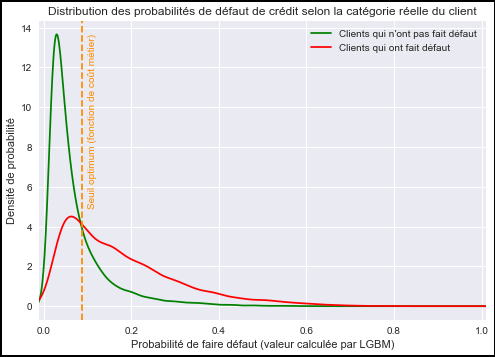

In [58]:
ser_predictproba_true0 = df_predictproba.loc[df_predictproba['y_true'] == 0, 'y_predict_proba']  # valeurs de predict_proba des client y_true == 0
ser_predictproba_true1 = df_predictproba.loc[df_predictproba['y_true'] == 1, 'y_predict_proba']

plt.style.use('seaborn')
plt.figure(edgecolor='black', linewidth=4)
plt.xlim(-0.01, 1.01)
bw_method = 0.15
ind = 1000
ser_predictproba_true0.plot(kind='kde', c='g', label='Clients qui n\'ont pas fait défaut', bw_method=bw_method, ind=ind)
ser_predictproba_true1.plot(kind='kde', c='r', label='Clients qui ont fait défaut', bw_method=bw_method)
plt.title('Distribution des probabilités de défaut de crédit selon la catégorie réelle du client')
plt.axline((seuil_optimum, 0), (seuil_optimum, 1), c='darkorange', ls='dashed')
plt.legend()
plt.xlabel('Probabilité de faire défaut (valeur calculée par LGBM)')
plt.ylabel('Densité de probabilité')
plt.annotate('Seuil optimum (fonction de coût métier)', color='darkorange', xy=(0.1, 5), rotation=90)
plt.show()

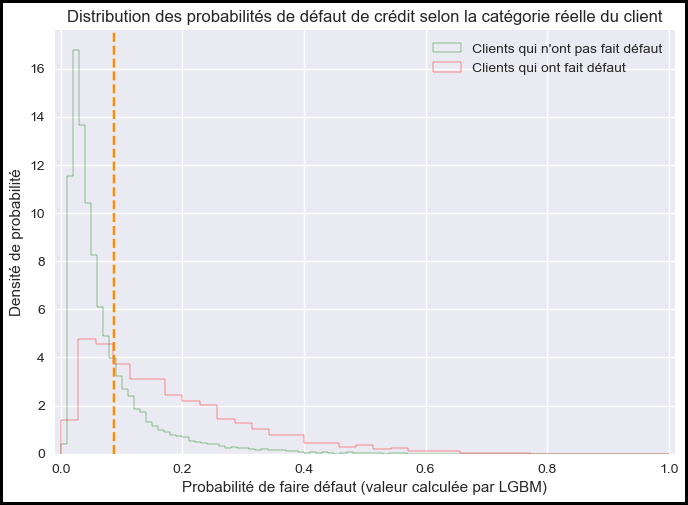

In [66]:
plt.figure(edgecolor='black', linewidth=4)
histtype='step'
ser_predictproba_true0.plot(kind='hist', color='g', label='Clients qui n\'ont pas fait défaut', bins=100, histtype=histtype, range=(0,1), density=True)
ser_predictproba_true1.plot(kind='hist', color='r', label='Clients qui ont fait défaut', bins=35, histtype=histtype, range=(0,1), density=True)
plt.title('Distribution des probabilités de défaut de crédit selon la catégorie réelle du client')
plt.axline((seuil_optimum, 0), (seuil_optimum, 1), c='darkorange', ls='dashed')
plt.legend()
plt.xlabel('Probabilité de faire défaut (valeur calculée par LGBM)')
plt.ylabel('Densité de probabilité')
# plt.annotate('Seuil optimum (fonction de coût métier)', color='darkorange', xy=(0.1, 1000), rotation=90)
plt.xlim(-0.01, 1.01)
# plt.ylim(0, 450)
plt.show()

###### Compte de clients

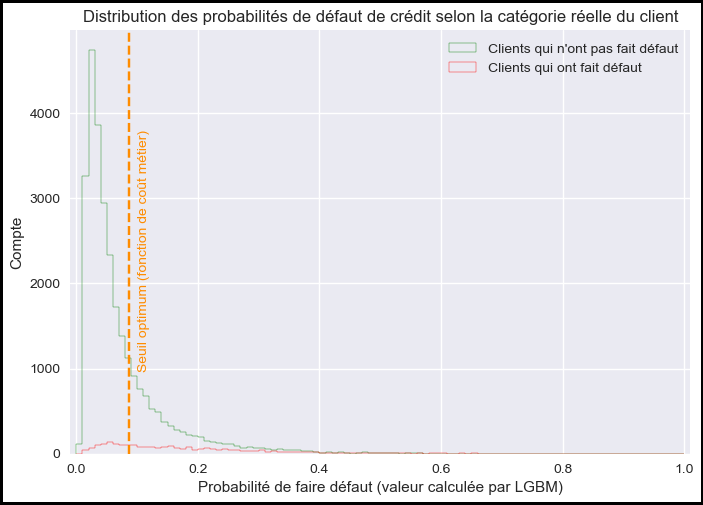

In [67]:
plt.figure(edgecolor='black', linewidth=4)
plt.xlim(-0.01, 1.01)
ser_predictproba_true0.plot(kind='hist', color='g', label='Clients qui n\'ont pas fait défaut', range=(0,1), bins=100, histtype=histtype)
ser_predictproba_true1.plot(kind='hist', color='r', label='Clients qui ont fait défaut', range=(0,1), bins=100, histtype=histtype)
plt.title('Distribution des probabilités de défaut de crédit selon la catégorie réelle du client')
plt.axline((seuil_optimum, 0), (seuil_optimum, 1), c='darkorange', ls='dashed')
plt.legend()
plt.xlabel('Probabilité de faire défaut (valeur calculée par LGBM)')
plt.ylabel('Compte')
plt.annotate('Seuil optimum (fonction de coût métier)', color='darkorange', xy=(0.1, 1000), rotation=90)
plt.show()

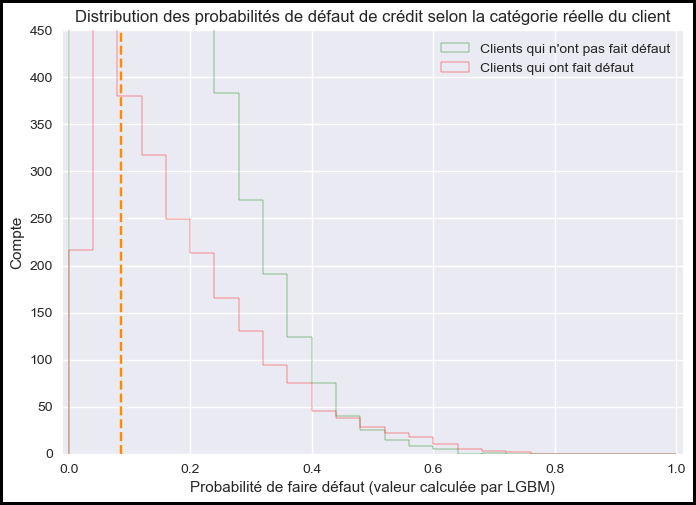

In [69]:
plt.figure(edgecolor='black', linewidth=4)
ser_predictproba_true0.plot(kind='hist', color='g', label='Clients qui n\'ont pas fait défaut', bins=25, histtype='step', range=(0,1))
ser_predictproba_true1.plot(kind='hist', color='r', label='Clients qui ont fait défaut', bins=25, histtype='step', range=(0,1))
plt.title('Distribution des probabilités de défaut de crédit selon la catégorie réelle du client')
plt.axline((seuil_optimum, 0), (seuil_optimum, 1), c='darkorange', ls='dashed')
plt.legend()
plt.xlabel('Probabilité de faire défaut (valeur calculée par LGBM)')
plt.ylabel('Compte')
# plt.annotate('Seuil optimum (fonction de coût métier)', color='darkorange', xy=(0.1, 1000), rotation=90)
plt.xlim(-0.01, 1.01)
plt.ylim(0, 450)
plt.show()

# Feature importance globale

In [423]:
clf_best_params

LGBMClassifier(learning_rate=0.05, min_data_in_leaf=40, num_iterations=200,
               num_leaves=15, verbose=-1)

## Outil interne de LGBM : feature_importances_

Extrait de la doc de LGBM :

Paramètre __importance_type__ (str, optional (default='split')) – The type of feature importance to be filled into __feature_importances___   
If ‘split’, result contains numbers of times the feature is used in a model.   
If ‘gain’, result contains total gains of splits which use the feature.  
  
Attribut __feature_importances___ :  
The feature importances (the higher, the more important).

In [425]:
feature_importances = clf_best_params.feature_importances_
print("Shape :", feature_importances.shape)
print(feature_importances)

Shape : (431,)
[ 22  33   1   0   0   2  24  57  37   0   9  27  28   1   2  52  39  12  26  40   0   0   2   0   0   0  32   0   3  19   2   0   0   0   0   5   0   0 206 138 134
 134   4   0   2   1   0   3   0   3   0   0   0   1   0   0   1   2   1   0   0   0   0   0   0   1   1   1   1   0   1   0   3   0   0   0   0   0   0   1   0   1
   0   0   0   0   4   6   0   0  14   0   9   8   0  11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   9   0  10  13   3
  24 132   0  20  10   2   0  14   3   1   0   0  27  12  13   3   1  26   5  11   1   4   0   1   0   0   0   1   3   1  52   6   0   8  14  16   5   0   0  19  12
   4  15   6  11  10  14  18   1   0   1   0   0   0   6   0   0  10   2  13   1  13   1   2   0   0   5   4  11  10   0   2   3   0   0   1   0   1   0   0   0   2
   1   7   5   1   0   3   1   0   1   0  18   3  10   1   1   2   0   5   5   1   0   1   5   0   0   1   4   1   3  35   6   3   9  14   3   2   0   2   2   1

In [426]:
features_and_importances = sorted(zip(X_split_train.columns, feature_importances), key = lambda x : x[1], reverse=True)
features_and_importances

[('ORGANIZATION_TYPE', 206),
 ('EXT_SOURCE_1', 138),
 ('EXT_SOURCE_2', 134),
 ('EXT_SOURCE_3', 134),
 ('PAYMENT_RATE', 132),
 ('INSTAL_AMT_PAYMENT_SUM', 69),
 ('APPROVED_CNT_PAYMENT_MEAN', 68),
 ('INSTAL_DPD_MEAN', 61),
 ('AMT_ANNUITY', 57),
 ('DAYS_BIRTH', 52),
 ('ACTIVE_DAYS_CREDIT_MAX', 52),
 ('CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 44),
 ('OWN_CAR_AGE', 40),
 ('DAYS_EMPLOYED', 39),
 ('AMT_GOODS_PRICE', 37),
 ('PREV_CNT_PAYMENT_MEAN', 35),
 ('POS_MONTHS_BALANCE_SIZE', 34),
 ('CODE_GENDER', 33),
 ('OCCUPATION_TYPE', 32),
 ('POS_SK_DPD_DEF_MEAN', 32),
 ('NAME_FAMILY_STATUS', 28),
 ('NAME_EDUCATION_TYPE', 27),
 ('BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 27),
 ('DAYS_ID_PUBLISH', 26),
 ('BURO_AMT_CREDIT_SUM_DEBT_MEAN', 26),
 ('AMT_CREDIT', 24),
 ('ANNUITY_INCOME_PERC', 24),
 ('APPROVED_AMT_DOWN_PAYMENT_MAX', 24),
 ('INSTAL_PAYMENT_DIFF_MEAN', 23),
 ('NAME_CONTRACT_TYPE', 22),
 ('BURO_DAYS_CREDIT_MAX', 20),
 ('CC_CNT_DRAWINGS_CURRENT_VAR', 20),
 ('REGION_RATING_CLIENT_W_CITY', 19),
 ('ACTIVE_AMT_C

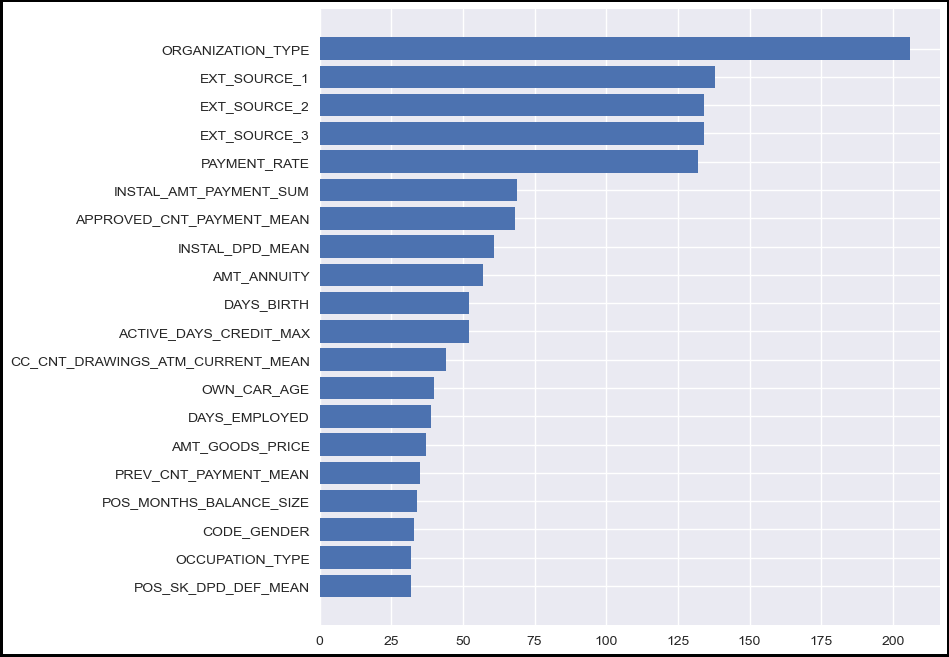

In [427]:
features_and_importances = np.array(features_and_importances)

plt.figure(figsize=(8,8), edgecolor='black', linewidth=4)
plt.style.use('seaborn')
plt.barh(features_and_importances[:20,0][::-1], features_and_importances[:20,1][::-1].astype(float));

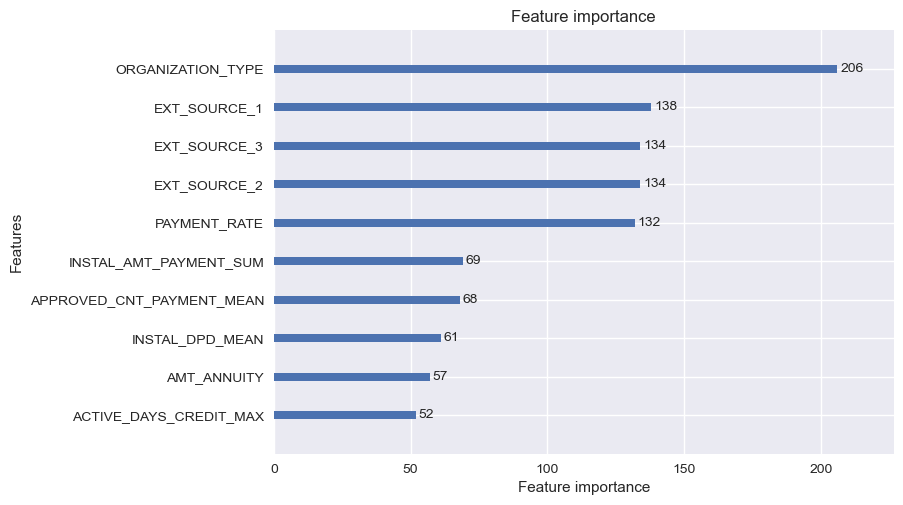

In [428]:
plot_importance(clf_best_params, max_num_features=10, importance_type='split');

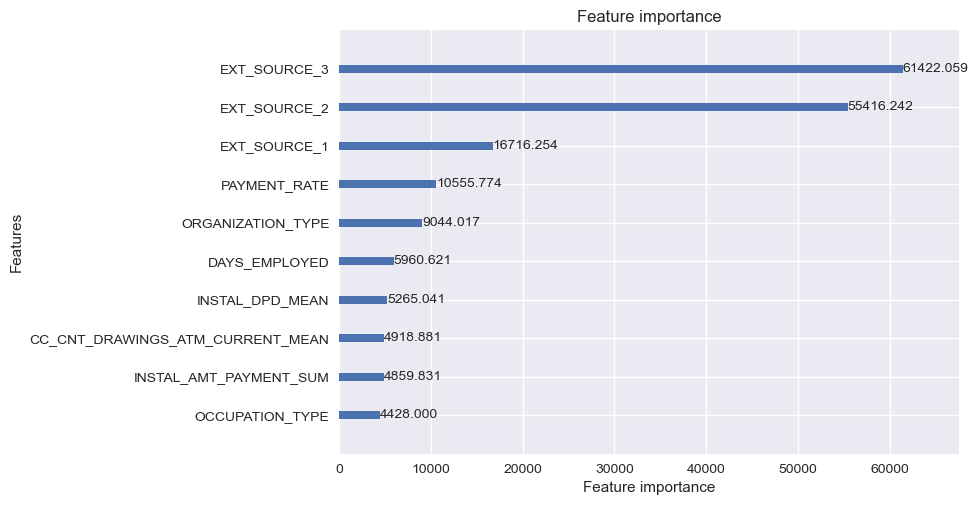

In [429]:
plot_importance(clf_best_params, max_num_features=10, importance_type='gain');

## Rapport ELI5

In [434]:
import eli5
print("importance_type (str, optional) – A way to get feature importance. Possible values are:"
"\n\n1) 'gain' - the average gain of the feature when it is used in trees (default) :")
display(eli5.show_weights(clf_best_params, importance_type='gain'))
print("2) 'split' - the number of times a feature is used to split the data across all trees :")
display(eli5.show_weights(clf_best_params, importance_type='split'))
print("Note : les valeurs de ELI5 sont normalisées (somme=1)")

importance_type (str, optional) – A way to get feature importance. Possible values are:

1) 'gain' - the average gain of the feature when it is used in trees (default) :


Weight,Feature
0.2237,EXT_SOURCE_3
0.2018,EXT_SOURCE_2
0.0609,EXT_SOURCE_1
0.0384,PAYMENT_RATE
0.0329,ORGANIZATION_TYPE
0.0217,DAYS_EMPLOYED
0.0192,INSTAL_DPD_MEAN
0.0179,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN
0.0177,INSTAL_AMT_PAYMENT_SUM
0.0161,OCCUPATION_TYPE


2) 'split' - the number of times a feature is used to split the data across all trees :


Weight,Feature
0.0736,ORGANIZATION_TYPE
0.0493,EXT_SOURCE_1
0.0479,EXT_SOURCE_2
0.0479,EXT_SOURCE_3
0.0471,PAYMENT_RATE
0.0246,INSTAL_AMT_PAYMENT_SUM
0.0243,APPROVED_CNT_PAYMENT_MEAN
0.0218,INSTAL_DPD_MEAN
0.0204,AMT_ANNUITY
0.0186,ACTIVE_DAYS_CREDIT_MAX


Note : les valeurs de ELI5 sont normalisées (somme=1)


ELI5 se contente simplement de normaliser des données récupérées dans les attributs de LGBM.

## Permutation importance avec sklearn

Pour l'estimation de la feature importance globale, l'utilisation de la __Permutation Importance est plus pertinente__ que les outils internes de LGBM reposant sur des nb de splits ou des coefs d'impuretés d'arbres de décision, car ces outils internes ont de nombreux défauts.

In [431]:
results = permutation_importance(clf_best_params,
                                 X_split_train,
                                 y_split_train,
                                 scoring='roc_auc',
                                 n_repeats=1,
                                 max_samples=1.0)

pickle.dump(results, open('results_permutation_importance.pkl', 'wb'))

In [249]:
results = pickle.load(open('results_permutation_importance.pkl', 'rb'))

In [250]:
importances_mean = results.importances_mean

features_and_importances = sorted(zip(X_split_train.columns, importances_mean), key = lambda x : x[1], reverse=True)
features_and_importances

[('EXT_SOURCE_2', 0.034931597490862165),
 ('EXT_SOURCE_3', 0.03347588069735419),
 ('EXT_SOURCE_1', 0.01156799883628834),
 ('PAYMENT_RATE', 0.006738155355768383),
 ('ORGANIZATION_TYPE', 0.005035054267855665),
 ('AMT_ANNUITY', 0.004421123645087954),
 ('APPROVED_CNT_PAYMENT_MEAN', 0.0043692878902683585),
 ('CODE_GENDER', 0.0043150176613879765),
 ('INSTAL_AMT_PAYMENT_SUM', 0.004111031851858904),
 ('INSTAL_DPD_MEAN', 0.004084504740190398),
 ('OWN_CAR_AGE', 0.0029923465114252146),
 ('AMT_GOODS_PRICE', 0.0027246776893654623),
 ('DAYS_EMPLOYED', 0.002519435235218803),
 ('NAME_EDUCATION_TYPE', 0.0023540778332644674),
 ('DAYS_BIRTH', 0.0021563697930941927),
 ('ACTIVE_DAYS_CREDIT_MAX', 0.0017446009715404998),
 ('NAME_FAMILY_STATUS', 0.0014861450803680398),
 ('POS_MONTHS_BALANCE_SIZE', 0.0013849194800272802),
 ('CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 0.0013209641329217092),
 ('BURO_AMT_CREDIT_SUM_DEBT_MEAN', 0.0012714108514702005),
 ('APPROVED_AMT_DOWN_PAYMENT_MAX', 0.001098067783482426),
 ('AMT_CREDI

Somme des feature importances (avant normalisation) :  1.0


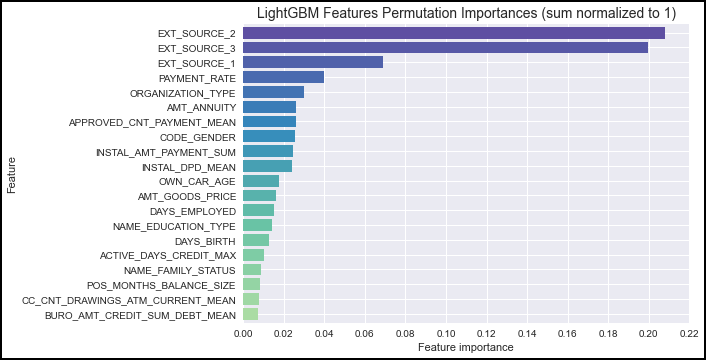

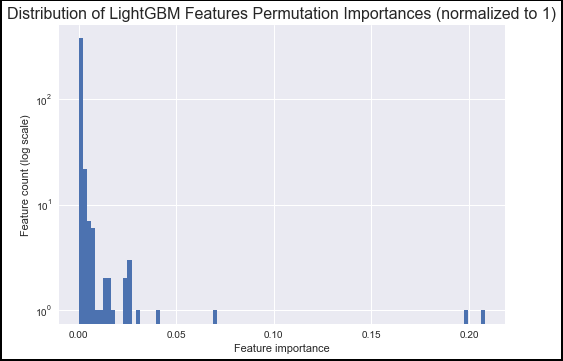

In [258]:
# Somme des feature importances
features_and_importances = np.array(features_and_importances)
somme = features_and_importances[:,1].astype(float).sum()
print("Somme des feature importances (avant normalisation) : ", round(somme, 3))

# Normalisation
features_and_importances[:,1] = features_and_importances[:,1].astype(float) / somme

# Chart 'LightGBM Features Permutation Importances'
nb_features = 20
plt.style.use('seaborn')
fig = plt.figure(edgecolor='black', linewidth=4)
plt.title('LightGBM Features Permutation Importances (sum normalized to 1)', size=14)
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.barh(features_and_importances[:nb_features,0][::-1], features_and_importances[:nb_features,1][::-1].astype(float),
         color=[Spectral(0.7+0.3*i/(nb_features-1)) for i in range(nb_features)])
plt.xticks([i*0.02 for i in range(12)])
plt.ylim(-0.6,nb_features-0.4)
joblib.dump(fig, './dashboard_streamlit/src/figure_features_permutation_importances_for_datascientist.joblib')
plt.show()

# Chart 'Distribution of LightGBM Features Permutation Importances'
plt.figure(edgecolor='black', linewidth=4)
plt.yscale("log")
plt.xlabel('Feature importance')
plt.ylabel('Feature count (log scale)')
plt.title('Distribution of LightGBM Features Permutation Importances (normalized to 1)', size=16)
plt.hist(features_and_importances[:,1].astype(float), bins=100)
plt.show()


# Feature importance locale avec SHAP

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

Currently TreeExplainer can only handle models with categorical splits when feature_perturbation="tree_path_dependent" and no background data is passed.  
Please try again using _shap.TreeExplainer(model, feature_perturbation="tree_path_dependent"_

_len(shap_values)_   retourne 2   car 2 classes (non défaut (0) et défaut de paiement (1))  

Tree-based models have properties that let us infer the importance of a feature. For each decision tree, we can compute the mean decrease in impurity for each feature - i.e., how impactful the feature is in reducing the uncertainty (classifiers) or variance (regressors) of the decision tree prediction. This value is also known as the gini importance score. For each tree based model in our list of trained models, we can leverage the sklearn feature_importance implementation and visualize the average importance of each variable.

Note that for the Tree SHAP implmementation the margin output of the model is explained, not the trasformed output (such as a probability for logistic regression). This means that __the units of the SHAP values for this model are log odds ratios__. 

In [316]:
# Seuil qui conduit au maximum de la fonction gain métier et log-odd correspondant :
print("seuil_optimum :", round(seuil_optimum,3))
print("log-odd équivalent:", round(conversion_proba_vers_logodd(seuil_optimum), 2))

seuil_optimum : 0.087
log-odd équivalent: -2.35


In [317]:
import shap
shap.initjs()    # nécessaire pour tracer les force plots
explainer = shap.TreeExplainer(clf_best_params)

Il y a un décalage de 2.87 points de log-odd entre SHAP et le classifieur (lorsque le log-odd est de -2.87, SHAP indique 0).  
Il faut prendre une base_value de -2.87 pour que les valeurs de SHAP > 0 soient des positifs tels que retournés par le classifieur LGBM.  
Il faut prendre une base_value de -0.53 (2.34-2.87) pour que les valeurs de SHAP positives correspondent à la fonction coût métier.  


In [416]:
# NOUVELLE FCT COUT
# sample_idx = 157905   # classe true y=0, pred y=0 (proba=0.014, log-odd = -4.22, Shap avant base_value = -1.41)
sample_idx = 204620   # classe true y=1, pred y=0 (proba=0.083, log-odd = -2.40, Shap avant base_value = 0.41)
# sample_idx = 28554   # classe true y=1, pred y=0 (proba=0.493, log-odd = -0.03, Shap avant base_value = 2.78)
# sample_idx = 30546   # classe true y=0, pred y=0 (proba=0.104, log-odd = -2.15, Shap avant base_value = 0.66)
# random_sample_idx = X_split_valid.sample(1).index ; sample_idx = random_sample_idx[0]   # échantillon random

proba = float(clf_best_params.predict_proba(X_split_valid.loc[[sample_idx]])[:,1])   # proba retournée par le classifieur LGBM

print(f"sample_idx = {sample_idx}, "
      f"classe (true) = {int(y_split_valid[sample_idx])}, "
      f"classe (pred) = {int(clf_best_params.predict(X_split_valid.loc[[sample_idx]]))}, "
      f"predict_proba = {round(proba, 3)}, "
      f"log odds = {round(conversion_proba_vers_logodd(proba), 2)}"
     )   

shap_values = explainer.shap_values(X_split_valid.loc[[sample_idx]])

sample_idx = 204620, classe (true) = 1, classe (pred) = 0, predict_proba = 0.083, log odds = -2.4


Il y a un décalage de 2.81 points de log-odd entre SHAP et le classifieur LGBM (lorsque le log-odd vaut 0, SHAP vaut 2.81).  
Il faut prendre une base_value de -2.81 pour que les valeurs de SHAP > 0 soient des positifs tels que retournés par le classifieur LGBM.  
Il faut prendre une base_value de -0.46 (2.35-2.81) pour que les valeurs de SHAP positives correspondent aux clients positifs (défaut de crédit) de la fonction coût métier.  

## SHAP values

In [324]:
shap_values[1].shape

(1, 431)

In [325]:
df_shap = pd.DataFrame({'SHAP value' : shap_values[1][0], 'feature' : X_split_valid.columns})
df_shap.sort_values(by='SHAP value', inplace=True)
df_shap

,SHAP value,feature
41,-0.527714,EXT_SOURCE_3
16,-0.113311,DAYS_EMPLOYED
1,-0.101177,CODE_GENDER
26,-0.061608,OCCUPATION_TYPE
18,-0.057666,DAYS_ID_PUBLISH
...,...,...
15,0.080260,DAYS_BIRTH
39,0.081558,EXT_SOURCE_1
7,0.112064,AMT_ANNUITY
325,0.216676,INSTAL_AMT_PAYMENT_SUM


## Bar plot

### shap.barplot()

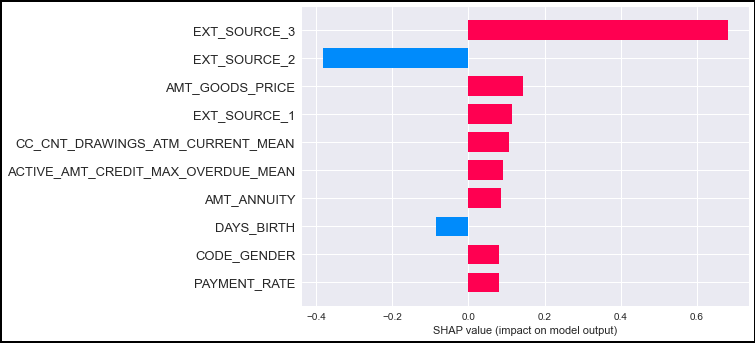

In [307]:
plt.figure(edgecolor='black', linewidth=4)
shap.bar_plot(shap_values[1][0],
              feature_names=X_split_valid.columns,
              max_display=10)

### Customized bar plot of SHAP values

In [398]:
def shap_barplot(df_shap):
    """Trace le barplot horizontal de 10 SHAP values (5 contributions les plus positives et 5 contributions les plus négatives sur la proba de défaut)
    Args :
    - df_shap (dataframe) : SHAP values and feature names.
    Returns :
    - tracé matplotlib.
    """
    # Préparation des données de la feature
    df = df_shap.sort_values(by='SHAP value', ascending=False)
    df = df.head(5).append(df.tail(5)).copy()

    # Tracé
    plt.style.use('seaborn')
    fig = plt.figure(edgecolor='black', linewidth=4)
    colors = [RdYlGn(0.05*i) for i in range(5)] + [RdYlGn(0.8 + 0.04*i) for i in range(5)]
    plt.barh(width=df['SHAP value'], y=df['feature'], color=colors)
    plt.xlabel('SHAP value')
    plt.ylabel('Features (top 5 contributors, both ways)')
    fig.suptitle('Impact on model output (credit default)', y=0.92, size=14)
    fig.show()

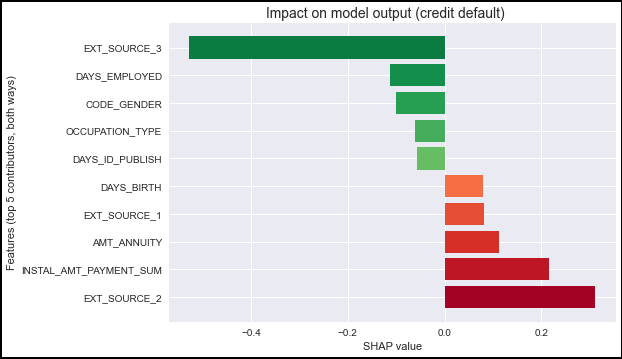

In [399]:
shap_barplot(df_shap)

## Force plot ajusté pour la fonction coût métier

### Sans ajustement

In [314]:
shap.plots.force(base_value=0,
                shap_values=shap_values[1][0],
                feature_names=X_split_valid.columns,
                out_names="Score")#, matplotlib=True)

### Avec ajustement

"Score > 0"   équivaut à    "client en défaut de paiement" (selon la fonction de coût métier).  
Note : la base value n'a pas de signification physique particulière (c'est simplement un décalage pour avoir une relation simple entre le score et la catégorie (défaut) du client.  

In [315]:
shap.plots.force(base_value=-0.46,
                shap_values=shap_values[1][0],
                feature_names=X_split_valid.columns,
                out_names="Score")

## Importance globale par SHAP

In [234]:
df_sample = X_split_valid.sample(10000)
shap_values = explainer.shap_values(df_sample)

### Summary plot

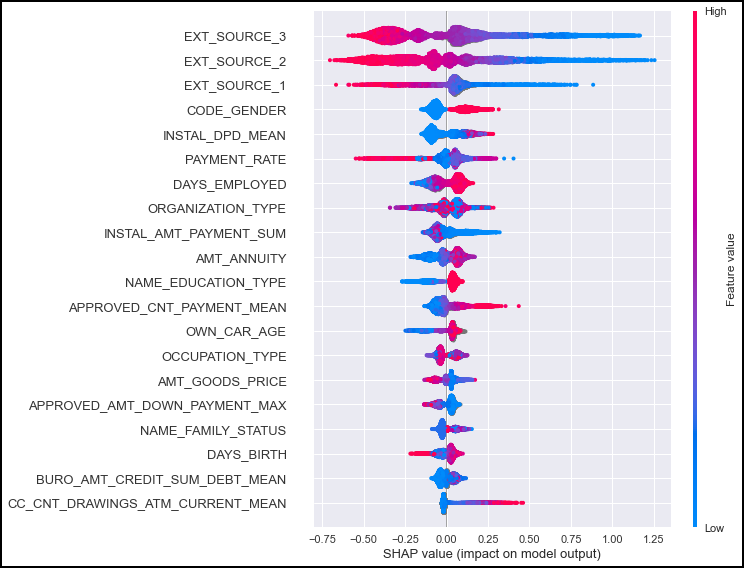

In [262]:
fig = plt.figure(edgecolor='black', linewidth=4)
shap.summary_plot(shap_values[1],
                  features = df_sample,
                  feature_names=X_split_valid.columns)

# Sérialisation
joblib.dump(fig, './dashboard_streamlit/src/figure_summary_plot_shap_for_datascientist.joblib')

fig.show()

# Test d'explication contrefactuelle : application à un candidat dont le crédit est refusé par le modèle

https://christophm.github.io/interpretable-ml-book/counterfactual.html

Candidat choisi : proba true = 0.084. On va l'aider à obtenir un crédit (seuil de proba = 0.088).  

In [ ]:
sample_idx = 42693   # classe true y=0, pred y=0 (proba=0.084, log-odd = -2.38, Shap avant base_value = 0.49)

proba = float(clf_best_cv.predict_proba(X_split_valid.loc[[sample_idx]])[:,1])   # proba retournée par le classifieur LGBM

print(f"sample_idx = {sample_idx}, "
      f"classe (true) = {int(y_split_valid[sample_idx])}, "
      f"classe (pred) = {int(clf_best_cv.predict(X_split_valid.loc[[sample_idx]]))}, "
      f"predict_proba = {round(proba, 3)}, "
      f"logg-odd = {round(conversion_proba_vers_logodd(proba), 2)}"
     )   

shap_values = explainer.shap_values(X_split_valid.loc[[sample_idx]])

df_before_counterfactual = X_split_valid.loc[[sample_idx]]
display(df_before_counterfactual)
print("AMT_ANNUITY = ", df_before_counterfactual['AMT_ANNUITY'][sample_idx])

shap.plots.force(base_value=-0.53,
                shap_values=shap_values[1][0],
                feature_names=X_split_valid.columns,
                out_names=r"Score"
               )

###### Essai 1 : AMT_ANNUITY

In [ ]:
df_after_counterfactual = df_before_counterfactual.copy()
df_after_counterfactual['AMT_ANNUITY'] = 16500

shap_values = explainer.shap_values(df_after_counterfactual)

shap.plots.force(base_value=-0.53,
                shap_values=shap_values[1][0],
                feature_names=X_split_valid.columns,
                out_names=r"Score"
               )

On observe une grosse limitation des arbres de décision : avec AMT_ANNUITY=16400, rien n'a bougé ; avec 16500, le Score est de 0.09.

###### Essai 2 : ORGANIZATION_TYPE (recherche de l'employeur idéal)

In [ ]:
df_after_counterfactual = df_before_counterfactual.copy()
for i in range(58):
    df_after_counterfactual['ORGANIZATION_TYPE'] = i
    shap_values = explainer.shap_values(df_after_counterfactual)
    print(f"ORGANIZATION_TYPE {i} a un score de : {shap_values[1][0].sum()-0.53}")

# Transfert vers une API basée sur FastAPI et qui tourne sur Heroku

## Entrainement et sauvegarde du modèle dans un fichier joblib

In [8]:
# Meilleur jeu de paramètre à l'issue de la CV : 
best_params = {'num_leaves': 15, 'num_iterations': 200, 'min_data_in_leaf' : 40, 'learning_rate' : 0.05}

In [10]:
clf_best_params = LGBMClassifier(**best_params, verbose=-1)
clf_best_params.fit(X_split_train, y_split_train, verbose=-1, categorical_feature=list_categorical_features)

[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40


LGBMClassifier(learning_rate=0.05, min_data_in_leaf=40, num_iterations=200,
               num_leaves=15, verbose=-1)

In [15]:
# le répertoire  ./api_ml  est le repository de l'API.
joblib.dump(clf_best_params, './api_ml/src/API_model.joblib')

['./api_ml/src/API_model.joblib']

In [9]:
clf_best_params = joblib.load('./api_ml/src/API_model.joblib')
clf_best_params

LGBMClassifier(learning_rate=0.05, min_data_in_leaf=40, num_iterations=200,
               num_leaves=15, verbose=-1)

## Export de clients vers l'API et vers le dashboard

### Tous les clients du set X_split_valid

In [382]:
joblib.dump(X_split_valid, './dashboard_streamlit/src/X_split_valid.joblib', compress=3)  # 100 Mo => 21 Mo avec compression
joblib.dump(y_split_valid, './dashboard_streamlit/src/y_split_valid.joblib')

['./dashboard_streamlit/src/y_split_valid.joblib']

### Echantillon de 100 clients du set df_test : df_test_sample

In [290]:
df_test_sample = df_test.drop(axis=1, labels=['index', 'SK_ID_CURR', 'TARGET']).sample(100)
joblib.dump(df_test_sample, './dashboard_streamlit/src/df_test_sample.joblib')
joblib.dump(df_test_sample, './api_ml/src/df_test_sample.joblib');

In [14]:
df_test_sample = joblib.load('./dashboard_streamlit/src/df_test_sample.joblib')
# df_test_sample

## Tests de l'API

### Conversion df -> json -> df

In [16]:
X_split_valid

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,...,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_

In [17]:
un_client = X_split_valid.iloc[[42]]
un_client

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,...,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_

In [18]:
un_client['EXT_SOURCE_1'].iloc[0]

nan

In [19]:
ORIENT = 'index'
json_un_client = un_client.to_json(orient=ORIENT)  
print("type :", type(json_un_client))
json_un_client

type : <class 'str'>


'{"153435":{"NAME_CONTRACT_TYPE":0,"CODE_GENDER":0,"FLAG_OWN_CAR":0,"FLAG_OWN_REALTY":1,"CNT_CHILDREN":0,"AMT_INCOME_TOTAL":81000.0,"AMT_CREDIT":239850.0,"AMT_ANNUITY":23494.5,"AMT_GOODS_PRICE":225000.0,"NAME_TYPE_SUITE":1,"NAME_INCOME_TYPE":3,"NAME_EDUCATION_TYPE":3,"NAME_FAMILY_STATUS":3,"NAME_HOUSING_TYPE":1,"REGION_POPULATION_RELATIVE":0.02461,"DAYS_BIRTH":-24434,"DAYS_EMPLOYED":null,"DAYS_REGISTRATION":-14532.0,"DAYS_ID_PUBLISH":-4613,"OWN_CAR_AGE":null,"FLAG_MOBIL":1,"FLAG_EMP_PHONE":0,"FLAG_WORK_PHONE":0,"FLAG_CONT_MOBILE":1,"FLAG_PHONE":0,"FLAG_EMAIL":0,"OCCUPATION_TYPE":12,"CNT_FAM_MEMBERS":1.0,"REGION_RATING_CLIENT":2,"REGION_RATING_CLIENT_W_CITY":2,"WEEKDAY_APPR_PROCESS_START":2,"HOUR_APPR_PROCESS_START":12,"REG_REGION_NOT_LIVE_REGION":0,"REG_REGION_NOT_WORK_REGION":0,"LIVE_REGION_NOT_WORK_REGION":0,"REG_CITY_NOT_LIVE_CITY":0,"REG_CITY_NOT_WORK_CITY":0,"LIVE_CITY_NOT_WORK_CITY":0,"ORGANIZATION_TYPE":57,"EXT_SOURCE_1":null,"EXT_SOURCE_2":0.2966406434,"EXT_SOURCE_3":null,"APAR

In [20]:
df2_un_client = pd.read_json(json_un_client, orient=ORIENT)
df2_un_client.index[0]

153435

In [21]:
X_split_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30752 entries, 81523 to 211017
Columns: 431 entries, NAME_CONTRACT_TYPE to CC_COUNT
dtypes: float64(377), int32(16), int64(38)
memory usage: 99.5 MB


In [22]:
un_client.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 153435 to 153435
Columns: 431 entries, NAME_CONTRACT_TYPE to CC_COUNT
dtypes: float64(377), int32(16), int64(38)
memory usage: 3.4 KB


In [23]:
df2_un_client.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 153435 to 153435
Columns: 431 entries, NAME_CONTRACT_TYPE to CC_COUNT
dtypes: float64(304), int64(127)
memory usage: 3.4 KB


In [24]:
y_pred_un_client = clf_best_params.predict_proba(un_client)[:,1]
y_pred_un_client

array([0.06573422])

In [25]:
y_pred_un_client = clf_best_params.predict_proba(df2_un_client)[:,1]
y_pred_un_client

array([0.06573422])

### Choix du HOST

In [329]:
import requests 
HOST = 'http://127.0.0.1:8000'
# HOST = 'https://project7-api-ml.herokuapp.com'

### Tests de prise en main de requests

#### Fonction ping()

In [27]:
response = requests.post(HOST + '/ping/?incoming_data=' + str(789456))
print("response.content :  ", response.content)
print("response.url :  ", response.url)

response.content :   b'"789456"'
response.url :   https://project7-api-ml.herokuapp.com/ping/?incoming_data=789456


#### Fonction ping2()

In [28]:
response = requests.post(HOST + '/ping2/' + str(789456))
print("response.content :  ", response.content)
print("response.url :  ", response.url)

response.content :   b'"789456"'
response.url :   https://project7-api-ml.herokuapp.com/ping2/789456


#### Fonction hello_id_client()   (get vs post)

In [29]:
# test post
response = requests.post(HOST + '/hello_id_client/' + str(55555))
print("response.content :  ", response.content)
print("response.url :  ", response.url)

response.content :   b'"Hello from hello_id_client(). Value = 55555. Type = <class \'int\'>"'
response.url :   https://project7-api-ml.herokuapp.com/hello_id_client/55555


In [30]:
# test get
response = requests.get(HOST + '/hello_id_client/' + str(55555))
print("response.content :  ", response.content)
print("response.url :  ", response.url)

response.content :   b'"Hello from hello_id_client(). Value = 55555. Type = <class \'int\'>"'
response.url :   https://project7-api-ml.herokuapp.com/hello_id_client/55555


#### Fonction return_seuil_optimum()

In [31]:
response = requests.post(HOST + '/optimum_threshold')
print("response.content :  ", response.content)
print("response.url :  ", response.url)
float(response.content)

response.content :   b'0.08700000000000001'
response.url :   https://project7-api-ml.herokuapp.com/optimum_threshold/


0.08700000000000001

In [32]:
float(requests.post(HOST + '/optimum_threshold').content)

0.08700000000000001

### Fonction fetch_data_id_client()   (json issu du pandas, passé sous forme de string)

Idéalement, il faudrait déclarer les 400+ variables (colonnes) du dataframe pour passer proprement un JSON à FastAPI.  
En pratique, j'ai passé le JSON sous sa forme de string, qui peut être retraité directement en DataFrame via pandas. 

In [33]:
response = requests.post('http://127.0.0.1:8000/predict_json/' + json_un_client)
print(response.content)

b'{"probability":0.06573422314795838}'


### Fonction predict_id_client()

In [34]:
id_client = 324806  # client du df_test_sample
df_test_sample[df_test_sample.index == id_client]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,...,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_VAR,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_VAR,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_VAR,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_AMT_DRAWINGS_POS_CURRENT_MAX,CC_AMT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_POS_CURRENT_SUM,CC_AMT_DRAWINGS_POS_CURRENT_VAR,CC_AMT_INST_MIN_REGULARITY_MIN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_AMT_INST_MIN_REGULARITY_MEAN,CC_AMT_INST_MIN_REGULARITY_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,CC_AMT_PAYMENT_CURRENT_MIN,CC_AMT_PAYMENT_CURRENT_MAX,CC_AMT_PAYMENT_CURRENT_MEAN,CC_AMT_PAYMENT_CURRENT_SUM,CC_AMT_PAYMENT_CURRENT_VAR,CC_AMT_PAYMENT_TOTAL_CURRENT_MIN,CC_AMT_PAYMENT_TOTAL_CURRENT_MAX,CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN,CC_AMT_PAYMENT_TOTAL_CURRENT_SUM,CC_AMT_PAYMENT_TOTAL_CURRENT_VAR,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_SUM,CC_AMT_RECEIVABLE_PRINCIPAL_VAR,CC_AMT_RECIVABLE_MIN,CC_AMT_RECIVABLE_MAX,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECIVABLE_SUM,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_TOTAL_RECEIVABLE_SUM,CC_AMT_TOTAL_RECEIVABLE_VAR,CC_CNT_DRAWINGS_ATM_CURRENT_MIN,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,CC_CNT_DRAWINGS_CURRENT_MIN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_CURRENT_VAR,CC_CNT_DRAWINGS_OTHER_CURRENT_MIN,CC_CNT_DRAWINGS_OTHER_CURRENT_

In [35]:
# test sur le modèle LGBM
response = requests.post(HOST + '/predict_id_client/' + str(id_client))
print("response.content :  ", response.content)
print("response.url :  ", response.url)

response.content :   b'{"probability":0.061978884017960416}'
response.url :   https://project7-api-ml.herokuapp.com/predict_id_client/324806


### Fonction fetchdata_id_client()

In [36]:
response = requests.post(HOST + '/fetch_data_id_client/' + str(id_client))
print("response.content :  ", response.content)
print("response.url :  ", response.url)

response.content :   b'"{\\"324806\\":{\\"NAME_CONTRACT_TYPE\\":0,\\"CODE_GENDER\\":1,\\"FLAG_OWN_CAR\\":1,\\"FLAG_OWN_REALTY\\":1,\\"CNT_CHILDREN\\":0,\\"AMT_INCOME_TOTAL\\":166500.0,\\"AMT_CREDIT\\":155938.5,\\"AMT_ANNUITY\\":14431.5,\\"AMT_GOODS_PRICE\\":126000.0,\\"NAME_TYPE_SUITE\\":7,\\"NAME_INCOME_TYPE\\":1,\\"NAME_EDUCATION_TYPE\\":4,\\"NAME_FAMILY_STATUS\\":1,\\"NAME_HOUSING_TYPE\\":1,\\"REGION_POPULATION_RELATIVE\\":0.025164,\\"DAYS_BIRTH\\":-15466,\\"DAYS_EMPLOYED\\":-3847.0,\\"DAYS_REGISTRATION\\":-2363.0,\\"DAYS_ID_PUBLISH\\":-4350,\\"OWN_CAR_AGE\\":8.0,\\"FLAG_MOBIL\\":1,\\"FLAG_EMP_PHONE\\":1,\\"FLAG_WORK_PHONE\\":0,\\"FLAG_CONT_MOBILE\\":1,\\"FLAG_PHONE\\":1,\\"FLAG_EMAIL\\":0,\\"OCCUPATION_TYPE\\":8,\\"CNT_FAM_MEMBERS\\":2.0,\\"REGION_RATING_CLIENT\\":2,\\"REGION_RATING_CLIENT_W_CITY\\":2,\\"WEEKDAY_APPR_PROCESS_START\\":0,\\"HOUR_APPR_PROCESS_START\\":14,\\"REG_REGION_NOT_LIVE_REGION\\":0,\\"REG_REGION_NOT_WORK_REGION\\":0,\\"LIVE_REGION_NOT_WORK_REGION\\":0,\\"REG_CI

In [37]:
df3_un_client = pd.read_json(eval(response.content), orient='index')
df3_un_client.T

,324806
NAME_CONTRACT_TYPE,0.0
CODE_GENDER,1.0
FLAG_OWN_CAR,1.0
FLAG_OWN_REALTY,1.0
CNT_CHILDREN,0.0
...,...
CC_SK_DPD_DEF_MAX,NaN
CC_SK_DPD_DEF_MEAN,NaN
CC_SK_DPD_DEF_SUM,NaN
CC_SK_DPD_DEF_VAR,NaN


### Fonction fetch_shap_id_client()

In [400]:
response = requests.post(HOST + '/fetch_shap_id_client/' + str(id_client))
print("response.content :  ", response.content)
print("response.url :  ", response.url)

response.content :   b'"{\\"40\\":{\\"SHAP value\\":0.5913499736,\\"feature\\":\\"EXT_SOURCE_2\\"},\\"1\\":{\\"SHAP value\\":0.13893724,\\"feature\\":\\"CODE_GENDER\\"},\\"38\\":{\\"SHAP value\\":0.0776409917,\\"feature\\":\\"ORGANIZATION_TYPE\\"},\\"26\\":{\\"SHAP value\\":0.0686736781,\\"feature\\":\\"OCCUPATION_TYPE\\"},\\"90\\":{\\"SHAP value\\":0.0639289518,\\"feature\\":\\"DEF_30_CNT_SOCIAL_CIRCLE\\"},\\"39\\":{\\"SHAP value\\":0.0513750327,\\"feature\\":\\"EXT_SOURCE_1\\"},\\"326\\":{\\"SHAP value\\":0.0475566465,\\"feature\\":\\"INSTAL_DAYS_ENTRY_PAYMENT_MAX\\"},\\"124\\":{\\"SHAP value\\":0.047213364,\\"feature\\":\\"PAYMENT_RATE\\"},\\"92\\":{\\"SHAP value\\":0.0441087815,\\"feature\\":\\"DEF_60_CNT_SOCIAL_CIRCLE\\"},\\"275\\":{\\"SHAP value\\":0.0410199487,\\"feature\\":\\"REFUSED_APP_CREDIT_PERC_MIN\\"},\\"293\\":{\\"SHAP value\\":0.0336917592,\\"feature\\":\\"REFUSED_DAYS_DECISION_MEAN\\"},\\"8\\":{\\"SHAP value\\":0.0263188381,\\"feature\\":\\"AMT_GOODS_PRICE\\"},\\"306\\

In [401]:
df_shap_test = pd.read_json(eval(response.content), orient='index')
df_shap_test

,SHAP value,feature
40,0.591350,EXT_SOURCE_2
1,0.138937,CODE_GENDER
38,0.077641,ORGANIZATION_TYPE
26,0.068674,OCCUPATION_TYPE
90,0.063929,DEF_30_CNT_SOCIAL_CIRCLE
...,...,...
298,-0.063069,POS_MONTHS_BALANCE_SIZE
16,-0.084695,DAYS_EMPLOYED
7,-0.097070,AMT_ANNUITY
19,-0.099152,OWN_CAR_AGE


In [402]:
id_client

324806

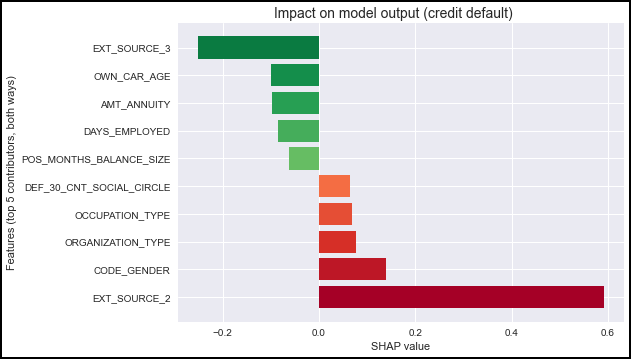

In [403]:
shap_barplot(df_shap_test)

## KDE proba de défaut (export du graphe précalculé)

['./dashboard_streamlit/src/figure_kde_distribution_proba_default_for_datascientist.joblib']

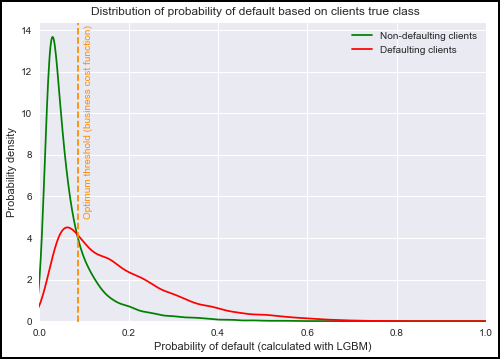

In [458]:
plt.style.use('seaborn')
fig = plt.figure(edgecolor='black', linewidth=4)

plt.xlim(0, 1)
bw_method = 0.15
ind = 1000
ser_predictproba_true0.plot(kind='kde', c='g', label='Non-defaulting clients', bw_method=bw_method, ind=ind)   # ser_predictproba_true0 est calculé dans le bloc "10.3.3.3 Distribution de predict_proba"
ser_predictproba_true1.plot(kind='kde', c='r', label='Defaulting clients', bw_method=bw_method)
fig.suptitle('Distribution of probability of default based on clients true class', y=0.92)
plt.legend()
plt.xlabel('Probability of default (calculated with LGBM)')
plt.ylabel('Probability density')
plt.ylim(-0.03, plt.ylim()[1])

plt.axline((seuil_optimum, 0), (seuil_optimum, 1), c='darkorange', ls='dashed')
plt.annotate('Optimum threshold (business cost function)', color='darkorange', xy=(0.1, 5), rotation=90)

joblib.dump(fig, './dashboard_streamlit/src/figure_kde_distribution_proba_default_for_datascientist.joblib')

## Histogramme proba de défaut (export du graphe précalculé)

['./dashboard_streamlit/src/figure_hist_distribution_proba_default_for_datascientist.joblib']

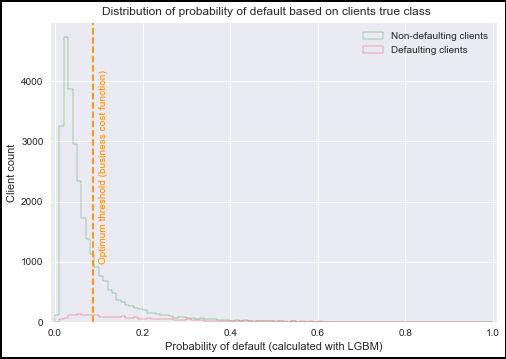

In [539]:
plt.style.use('seaborn')
fig = plt.figure(edgecolor='black', linewidth=4)

plt.xlim(-0.01, 1.01)
ser_predictproba_true0.plot(kind='hist', color='g', label='Non-defaulting clients', range=(0,1), bins=100, histtype='step')
ser_predictproba_true1.plot(kind='hist', color='r', label='Defaulting clients', range=(0,1), bins=100, histtype='step')
fig.suptitle('Distribution of probability of default based on clients true class', y=0.92)
plt.axline((seuil_optimum, 0), (seuil_optimum, 1), c='darkorange', ls='dashed')
plt.legend()
plt.xlabel('Probability of default (calculated with LGBM)')
plt.ylabel('Client count')
plt.annotate('Optimum threshold (business cost function)', color='darkorange', xy=(0.1, 1000), rotation=90)

joblib.dump(fig, './dashboard_streamlit/src/figure_hist_distribution_proba_default_for_datascientist.joblib')

## Plotting des principales features (export des graphes précalculés)

### Variables quantitatives

#### KDE plots

In [495]:
def export_kde(feature, xlim=(0,1), bw_method=0.15):
    """Trace et exporte le KDE d'une feature pour les clients : en défaut / pas en défaut.
    Args :
    - feature (string).
    - xlim (2-uplet) : bornes basse/haute du tracé.
    - bw_method : bande passante du KDE.
    Returns :
    - exporte une figure matplotlib (objet sérialisé joblib).
    """
    # Préparation des données pour le tracé de la densité de probabilité pour les clients en défaut / pas en défaut
    df = pd.DataFrame({feature:X_split_valid[feature], 'y_true':y_split_valid})
    ser_true0 = df.loc[df['y_true'] == 0, feature]  # valeurs de predict_proba des client y_true == 0
    ser_true1 = df.loc[df['y_true'] == 1, feature]
    
    # Préparation du tracé matplotlib
    plt.style.use('seaborn')
    fig = plt.figure(edgecolor='black', linewidth=4)
    ser_true0.plot(kind='kde', c='g', label='Non-defaulting clients', bw_method=bw_method, ind=None)
    ser_true1.plot(kind='kde', c='r', label='Defaulting clients', bw_method=bw_method, ind=None)
    fig.suptitle(f'Observed distribution of {feature} based on clients true class', y=0.92)
    plt.legend()
    plt.xlabel(feature)
    plt.ylabel('Probability density')
    plt.xlim(xlim)

    # Sérialisation
    joblib.dump(fig, './dashboard_streamlit/src/figure_kde_distribution_' + feature + '_for_datascientist.joblib')
    
    fig.show()

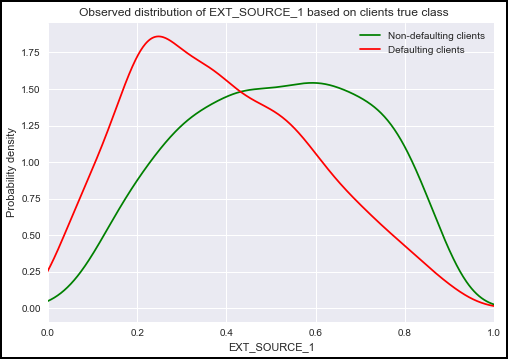

In [496]:
export_kde('EXT_SOURCE_1', bw_method=0.25)

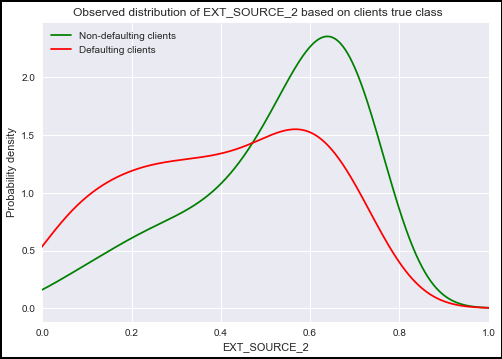

In [497]:
export_kde('EXT_SOURCE_2', bw_method=0.4)

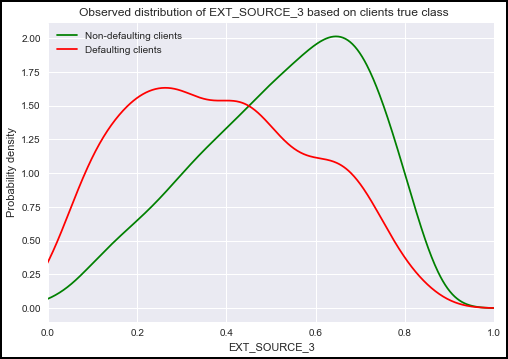

In [498]:
export_kde('EXT_SOURCE_3', bw_method=0.25)

In [499]:
# export_kde('PAYMENT_RATE', xlim=(0.0,0.13), bw_method=0.5)       # variable problématique (data douteuses)

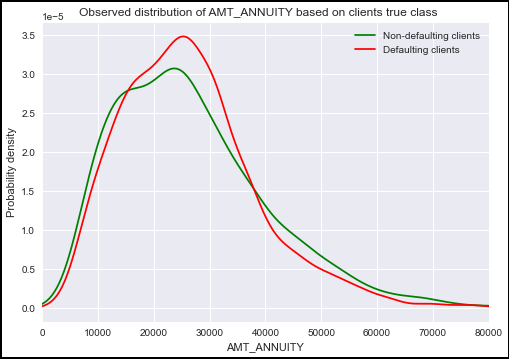

In [500]:
export_kde('AMT_ANNUITY', xlim=(0, 80000), bw_method=0.2)

#### Tracés des probas en fonction de la feature, dans des bins de même taille

On lisse sur 4000 clients, et on trace un point tous les 1000 clients.

In [ ]:
# feature = 'EXT_SOURCE_1'
# feature = 'EXT_SOURCE_2'
# feature = 'EXT_SOURCE_3'
# feature = 'PAYMENT_RATE'       # problématique
# feature = 'AMT_ANNUITY'
# feature = 'APPROVED_CNT_PAYMENT_MEAN'   # problématique
# feature = 'OWN_CAR_AGE'
# feature = 'DAYS_EMPLOYED'
# feature = 'DAYS_BIRTH'
# feature = 'AMT_CREDIT'

In [534]:
def export_line_plot(feature):
    """Trace et exporte le line plot de la proba de défaut en fonction des valeurs d'une feature.
    On lisse sur 4000 clients, et on trace un point tous les 1000 clients.
    Args :
    - feature (string).
    Returns :
    - exporte une figure matplotlib (objet sérialisé joblib).
    """
    target_bin_size = 4000

    # préparation des données
    df = pd.DataFrame({feature:X_split_valid[feature], 'y_true':y_split_valid})
    # df = pd.DataFrame({feature:X_split_train[feature], 'y_true':y_split_train})
    df = df.dropna().sort_values(axis=0, by=feature).copy()
    n_values = len(df)
    n_bins = int(np.ceil(n_values / target_bin_size))
    bin_size = int(np.floor(n_values / n_bins))
    index_bin_start = [bin_size*n for n in range(n_bins) ] + [int(bin_size*(n+0.25)) for n in range(n_bins) ] \
                        + [int(bin_size*(n+0.5)) for n in range(n_bins) ] + [int(bin_size*(n+0.75)) for n in range(n_bins) ]
    index_bin_start = sorted(index_bin_start)
    
    # calcul du proba de défaut de chaque bin
    proba_default = []
    feature_value_start = []
    for i in index_bin_start[2:-2]:
        some_bin = df.iloc[int(i-0.5*bin_size):int(i+0.5*bin_size)]
        some_bin_sum0 = (some_bin['y_true'] == 0).sum()
        some_bin_sum1 = (some_bin['y_true'] == 1).sum()
        some_bin_sum = some_bin_sum0 + some_bin_sum1
        proba_default_ = some_bin_sum1 / some_bin_sum
        proba_default.append(proba_default_)
        feature_value_start.append(df[feature].iloc[i])
    
    # Tracé
    plt.style.use('seaborn')
    fig = plt.figure(edgecolor='black', linewidth=4)
    plt.plot(feature_value_start, proba_default, color='k')
    ylim_high = plt.ylim()[1]
    plt.fill_between(x=feature_value_start, y1=proba_default, y2=0, color='r')
    plt.fill_between(x=feature_value_start, y1=proba_default, y2=1, color='limegreen')
    plt.ylabel('Observed probability of default')
    plt.xlabel(feature)
    fig.suptitle(f'Observed probability of default as a function of {feature}', y=0.92)
    plt.ylim(-0.004,max(ylim_high, 0.3))
    
    # Sérialisation
    joblib.dump(fig, './dashboard_streamlit/src/figure_lineplot_' + feature + '_for_bankclerk.joblib')

    fig.show()

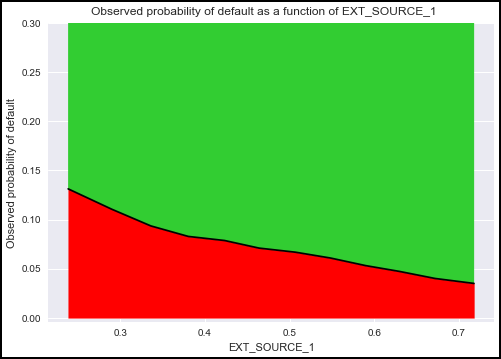

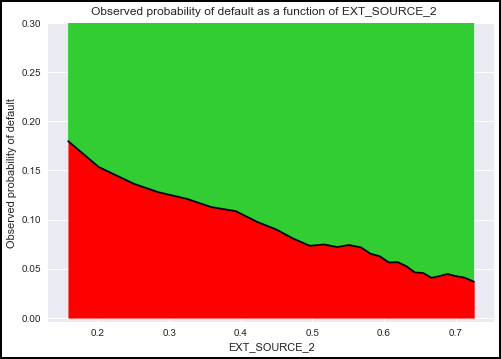

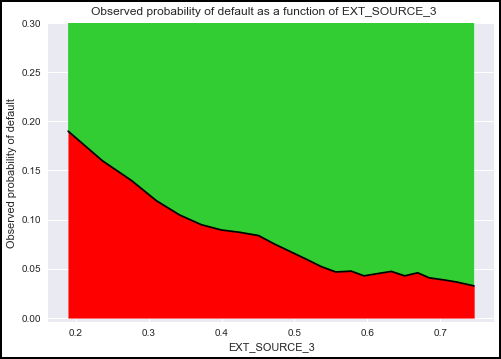

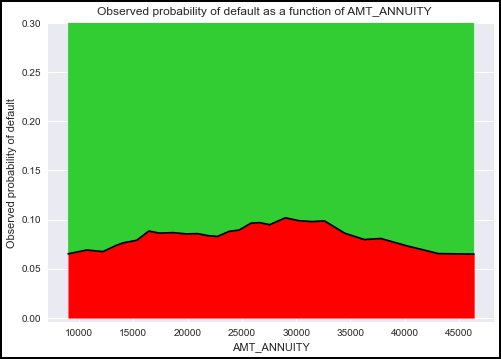

In [535]:
for feature in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_ANNUITY']:
    export_line_plot(feature)

#### Contour plots (bins d'effectif similaire)

In [536]:
def contour_plot(feature1, feature2):
    """Trace et exporte le contour plot de la proba de défaut en fonction des valeurs de deux features.
    On crée une grille de dimension n_bins * n_bins et on calcule la proba de défaut en chaque point de la grille.
    La grille est conçue de sorte à ce que toutes les mailles aient un effectif similaire.
    Args :
    - feature1 (string).
    - feature2 (string).
    Returns :
    - exporte une figure matplotlib (objet sérialisé joblib).
    """
    target_bin_size = 2000   # target population for each column / row of the grid

    # préparation des données
    df = pd.DataFrame({feature1:X_split_valid[feature1], feature2:X_split_valid[feature2], 'y_true':y_split_valid})
    df = df.dropna().copy()
    n_values = len(df)
    n_bins = int(np.ceil(n_values / target_bin_size))
    bin_size = int(np.floor(n_values / n_bins))
    index_bin_start = sorted([bin_size*n for n in range(n_bins)])
    ser1 = df[feature1].sort_values().copy()
    ser2 = df[feature2].sort_values().copy()
    
    # Filling of the grid
    grid_proba_default = np.full((n_bins, n_bins), -1.0)
    ser_true0 = (df['y_true'] == 0)
    ser_true1 = (df['y_true'] == 1)
    for i1, ind1 in enumerate(index_bin_start):  
        for i2, ind2 in enumerate(index_bin_start):  
            ser_inside_this_mesh = (df[feature1] > ser1.iloc[ind1]) & (df[feature2] > ser2.iloc[ind2]) \
                                            & (df[feature1] < ser1.iloc[ind1+bin_size]) & (df[feature2] < ser2.iloc[ind2+bin_size])
            sum_0 = (ser_inside_this_mesh & ser_true0).sum()  # sum of clients true0 inside this square bin
            sum_1 = (ser_inside_this_mesh & ser_true1).sum()
            sum_ = sum_0 + sum_1
            if sum_ == 0:
                proba_default = 1
            else :
                proba_default = sum_1 / sum_
            grid_proba_default[i2, i1] = proba_default
    
    # X, Y of the grid
    X = [ser1.iloc[i+int(bin_size/2)] for i in index_bin_start]
    Y = [ser2.iloc[i+int(bin_size/2)] for i in index_bin_start]
    
    # Tracé
    plt.style.use('seaborn')
    fig = plt.figure(edgecolor='black', linewidth=4)
    plt.contourf(X, Y, grid_proba_default, cmap='Reds')
    plt.colorbar(shrink=0.8)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    fig.suptitle(f'Observed probability of default as a function of {feature1} and {feature2}', y=0.92)
    
    # Sérialisation
#     joblib.dump(fig, './dashboard_streamlit/src/figure_contourplot_' + feature + '_for_bankclerk.joblib')

    fig.show()

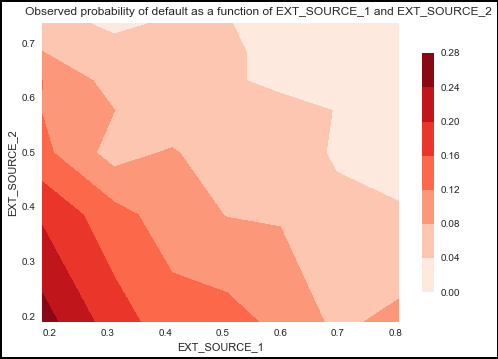

In [537]:
contour_plot('EXT_SOURCE_1', 'EXT_SOURCE_2')

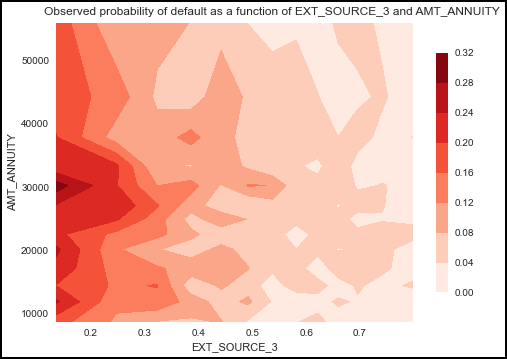

In [538]:
contour_plot('EXT_SOURCE_3', 'AMT_ANNUITY')

### Variables qualitatives

#### Suppression des NAN et des XNA des variables qualitatives

In [482]:
# for feat in list_categorical_features:
#     if 'NAN' in dict_categorical_features[feat]:
#         dict_categorical_features[feat].remove('NAN')
#     if 'XNA' in dict_categorical_features[feat]:
#         dict_categorical_features[feat].remove('XNA')

In [483]:
pprint(dict_categorical_features)

{'CODE_GENDER': ['F', 'M', 'XNA'],
 'EMERGENCYSTATE_MODE': ['NAN', 'No', 'Yes'],
 'FLAG_OWN_CAR': ['N', 'Y'],
 'FLAG_OWN_REALTY': ['N', 'Y'],
 'FONDKAPREMONT_MODE': ['NAN',
                        'not specified',
                        'org spec account',
                        'reg oper account',
                        'reg oper spec account'],
 'HOUSETYPE_MODE': ['NAN',
                    'block of flats',
                    'specific housing',
                    'terraced house'],
 'NAME_CONTRACT_TYPE': ['Cash loans', 'Revolving loans'],
 'NAME_EDUCATION_TYPE': ['Academic degree',
                         'Higher education',
                         'Incomplete higher',
                         'Lower secondary',
                         'Secondary / secondary special'],
 'NAME_FAMILY_STATUS': ['Civil marriage',
                        'Married',
                        'Separated',
                        'Single / not married',
                        'Unknown',
           

#### matplotlib barplot horizontal

In [484]:
def export_barplot(feature):
    """Trace et exporte le barplot horizontal d'une feature pour les clients : en défaut / pas en défaut.
    Args :
    - feature (string).
    Returns :
    - exporte une figure matplotlib (objet sérialisé joblib).
    """
    # Préparation des données de la feature
    df_feature = pd.DataFrame({feature:X_split_valid[feature], 'y_true':y_split_valid})

    # Calcul des probas de défaut pour chaque modalité de la feature
    probas_des_modalites = []
    cardinalite = len(dict_categorical_features[feature]) if feature != 'CODE_GENDER' else 2
    
    for index in range(cardinalite):  # on parcourt toutes les modalités de la feature
        df_feature_modalite = df_feature[df_feature[feature] == index]
        proba_defaut = df_feature_modalite['y_true'].sum() / len(df_feature_modalite)
        probas_des_modalites.append(proba_defaut)
    df_modalites = pd.DataFrame()
    df_modalites['modalites'] = dict_categorical_features[feature] if feature != 'CODE_GENDER' else ['Female', 'Male']
    df_modalites['probas'] = probas_des_modalites
    df_modalites.sort_values(by='probas', inplace=True)

    # Tracé
    plt.style.use('seaborn')
    fig = plt.figure(edgecolor='black', linewidth=4)
    plt.xlim(0,1)
    plt.ylim(-0.6,cardinalite-0.4)
    plt.barh(y=range(cardinalite), width=df_modalites['probas'], color='r')
    plt.barh(y=range(cardinalite), left=df_modalites['probas'], width=(1-df_modalites['probas']), color='limegreen', )
    plt.xlabel('Observed probability of default')
    plt.ylabel(feature)
    fig.suptitle(f'Observed probability of default as a function of {feature} based on clients true class', y=0.92)
    size = 6 if cardinalite > 30 else None
    plt.yticks(ticks=range(cardinalite), labels=df_modalites['modalites'], size=size)


    # Sérialisation
    joblib.dump(fig, './dashboard_streamlit/src/figure_barplot_' + feature + '_for_datascientist.joblib')

    fig.show()

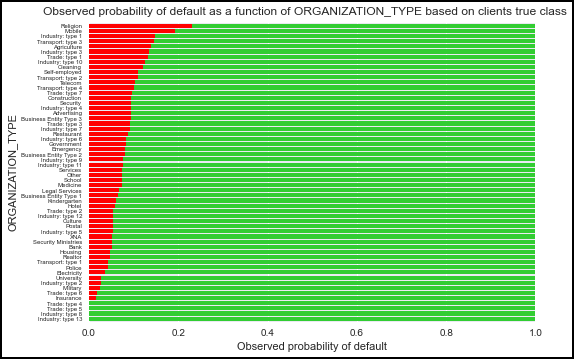

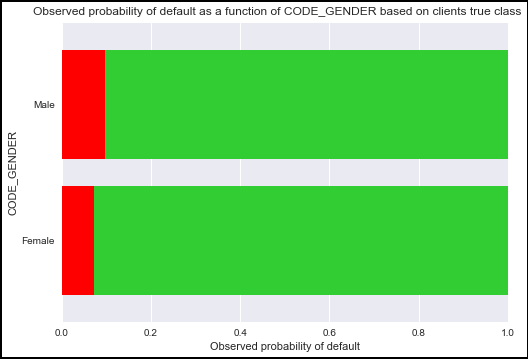

In [485]:
export_barplot('ORGANIZATION_TYPE')
export_barplot('CODE_GENDER')
# export_barplot('OCCUPATION_TYPE')

In [486]:
from random import randint
clients = [str(id) for id in df_test_sample.index]
size = len(clients)
client_index = randint(0, size-1)
clients[client_index]

'308268'